In [40]:
import numpy as np
import math
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import matplotlib.pyplot as plt
import seaborn as sns
import cirpy
from functools import partial
from drfp import DrfpEncoder
import matplotlib.pyplot as plt
import umap.umap_ as umap
import hdbscan

D:\Chem_conditions\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**SciFinder**
> *База данных индексирует статьи из более чем 50 000 научных журналов, начиная с 1907 года, а также патенты из 63 патентных ведомств, в том числе из РФ, Китая, Кореи, Индии.*

> *дополняет Reaxys*

> *больше данных для анализа (NMR, MS)*

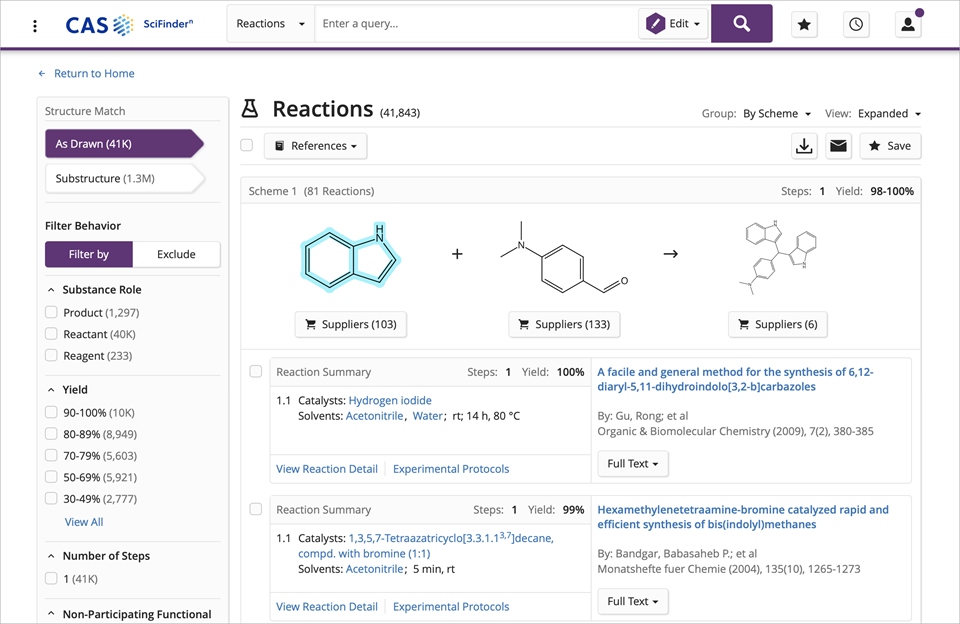

#### Качество и полнота данных

Важно помнить, что  качество химических данных довольно сложный аспект. Все базы данных контента, содержащие химические соединения, содержат ошибки. Эти ошибки могут возникать по ряду причин, включая ошибки в транскрипции, исторические ошибки (соединение было «правильным» при вводе, но позже было переохарактеризовано), проблемы с графическим представлением и множество других причин. Качество химической информации в открытом доступе, как правило, довольно низкое. Это не означает, что данные не представляют ценности, но необходимо соблюдать осторожность в отношении характера поставщика как органа власти. Конечно, нет центрального органа, ответственного за качество данных в открытом доступе. Базы данных с информацией о химической структуре, такие как PubChem, ChemIDPLus и ChemFinder и т. д., обычно считаются авторитетными с точки зрения достоверной информации. Однако эти источники также являются агрегаторами информации и подвержены риску увековечивания ошибок из исходных общедоступных данных и показаний. Ошибки в парах идентификаторов структуры распространены, а неточные представления структуры, особенно в отношении стереохимии, распространяются во многих базах данных. [1]

1. A.J. Williams
Public chemical compound databases
Curr. Opin Drug Discov. Dev., 11 (2008), pp. 393-404

Полнота данных зачастую определяется возможностью решить задачу с помощью этих данных. Данных довольно много, гораздо больше, чем необходимо. Получить широкую выборку в целом возможно, но сложно оценить действительно ли эта выборка репрезентативна. 

Плюс в самих базах химических данных не учитываются негативные случаи, когда реакция была опробована или расчитана, но не имеет развития. Поэтому считаем, что имеется информация только о позитивных случаях синтеза.

#### Обработка сырого датасета 

In [657]:
df = pd.read_csv('../data/interim/dataset_15k_pages_1_stage.csv')

In [658]:
df.head()

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,other_conditions_1,folder,file
0,31-480-CAS-42225,['119-53-9'],['134-81-6'],4,90%,Heterogeneous Swern Oxidation. Selective Oxida...,"Firouzabadi, H.","Phosphorus, Sulfur and Silicon and the Related...","['Dimethyl sulfoxide', 'Silica (chlorinated)',...",[],['Dichloromethane'],"5 min, -60 °C",NaN,NaN
1,31-480-CAS-32658,['119-53-9'],['134-81-6'],4,99%,Development of Odorless Thiols and Sulfides an...,"Nishide, Kiyoharu","Monatshefte fuer Chemie (2004), 135(2), 189-200","['Chlorosuccinimide', '1-(Methylthio)dodecane']",[],['Dichloromethane'],-40 °C,NaN,NaN
2,31-480-CAS-21387,['119-53-9'],['134-81-6'],4,91%,Development of Odorless Thiols and Sulfides an...,"Nishide, Kiyoharu","Monatshefte fuer Chemie (2004), 135(2), 189-200","['Oxalyl chloride', 'Dodecyl methyl sulfoxide']",[],['Dichloromethane'],-60 °C,NaN,NaN
3,31-480-CAS-36295,['119-53-9'],['134-81-6'],4,65%,Polymer-supported thioanisole: a versatile pla...,"Choi, Matthew Kwok Wai","Tetrahedron (2004), 60(12), 2875-2879","['tert-Butyl hydroperoxide', 'p-Toluenesulfoni...",['694440-72-7'],"['Dichloromethane', 'Water']",rt,NaN,NaN
4,31-480-CAS-22570757,['119-53-9'],['134-81-6'],4,96%,Alcohol Oxidation in the Presence of Methyl Ch...,"Davidovich, Yuriy A.","ChemistrySelect (2020), 5(23), 7013-7015","['Dimethyl sulfoxide', 'Chlorosulfuric acid, m...",[],['Dichloromethane'],25 °C → -78 °C,NaN,NaN


In [659]:
# Фильтрация по реакциям с одной стадией
df = df[df['stages_number'] == 1].reset_index().drop(['index'], axis=1)
df.head()

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,other_conditions_1,folder,file
0,31-480-CAS-24139,['119-53-9'],['134-81-6'],1,90%,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",['Nitric acid'],[],[],NaN,NaN,NaN
1,31-480-CAS-18071,['119-53-9'],['134-81-6'],1,86%,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7","['Pyridine', 'Copper sulfate pentahydrate']",[],['Water'],NaN,NaN,NaN
2,31-480-CAS-27637,['119-53-9'],['134-81-6'],1,95%,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",['Bismuth oxide (Bi2O3)'],[],"['Acetic acid', 'Glycol monoethyl ether']",NaN,NaN,NaN
3,31-480-CAS-25495,['119-53-9'],['134-81-6'],1,90%,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","['Ethanol, thallium salt']",[],['Ethanol'],NaN,NaN,NaN
4,31-480-CAS-37840,['119-53-9'],['134-81-6'],1,32%,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",['Phenylseleninyl benzeneseleninate'],[],['Tetrahydrofuran'],NaN,NaN,NaN


In [664]:
# Разделение other_condition на температуру, давление, время и pH
def split_conditions(conditions):
    if conditions is np.nan:
        return []
    conditions = conditions.replace(';', ',')
    return [
        condition.strip() for condition in conditions.split(',')
    ]
print("Before:\n\n", df[df['other_conditions_1'].notnull()]['other_conditions_1'])
df['other_conditions_1'] = df['other_conditions_1'].apply(split_conditions)
print("\n\nAfter:\n\n", df[df['other_conditions_1'].str.len() != 0]['other_conditions_1'])

Before:

 127              reflux
128         2 h, 100 °C
145       2.5 h, reflux
147           2 min, rt
149          6 h, 25 °C
              ...      
279756       3 h, 10 °C
279757     24 h, 100 °C
279758       2 h, 70 °C
279759     20 h, -40 °C
279760               rt
Name: other_conditions_1, Length: 233746, dtype: object


After:

 127              [reflux]
128         [2 h, 100 °C]
145       [2.5 h, reflux]
147           [2 min, rt]
149          [6 h, 25 °C]
               ...       
279756       [3 h, 10 °C]
279757     [24 h, 100 °C]
279758       [2 h, 70 °C]
279759     [20 h, -40 °C]
279760               [rt]
Name: other_conditions_1, Length: 233746, dtype: object


In [665]:
def parse_conditions(conditions, keywords):
    conditions_dict = {
        condition_type: [] for condition_type in keywords.keys()
    }
    for condition in conditions:
        is_match_found = False
        for condition_type, type_keywords in keywords.items():
            for keyword in type_keywords:
                if keyword in condition:
                    conditions_dict[condition_type].append(condition)
                    is_match_found = True
                    break
            if is_match_found:
                break
        if not is_match_found:
            raise ValueError('Unhandled conditions')
    return conditions_dict.values()

keywords = {
    'temperature_1': [' °C', ' K', 'rt', 'heated', 'cooled', 'reflux'],
    'pressure_1': ['Pa', ' atm', ' psi', 'bar', ' torr', ' kg/cm2', 'mm'],
    'time_1': [' d', ' h', ' min', ' s', 'overnight', ' ms', ' w', ' mo'],
    'pH_1': ['pH', 'acidified', 'neutralized', 'basified'],
}
parse_conditions = partial(parse_conditions, keywords=keywords)
conditions = df['other_conditions_1'].apply(parse_conditions)
for column_name, column in zip(keywords.keys(), zip(*conditions)):
    df[column_name] = column

df[keywords.keys()].iloc[2000:2010]

,temperature_1,pressure_1,time_1,pH_1
2000,[rt],[],[],[]
2001,[50 °C],[],[5 h],[]
2002,[reflux],[],[13 h],[]
2003,[80 °C],[],[4 h],[]
2004,[rt → 130 °C],[],[20 h],[]
2005,[140 °C],[],[18 h],[]
2006,[130 °C],[],[6 h],[]
2007,[rt],[],[],[]
2008,[30 °C],[],[24 h],[]
2009,[75 °C],[],[9 h],[]


In [666]:
# Стандартизация времени, температуры, давления и pH
def convert_value(value_string, conversion_mapping):
    for measure, conversion in conversion_mapping.items():
        if measure in value_string:
            value_string = value_string.replace(measure, '')
            return conversion(value_string)
    return value_string


def parse_time(time_list, conversion_mapping):
    converted_time_list = []
    for time_string in time_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            time_string = time_string.replace(symbol, '')
        delimiters = [' - ']
        for delimiter in delimiters:
            if delimiter in time_string:
                time_range = time_string.split()
                time_string = parse_range(time_range)
        converted_time_list.append(
            convert_value(time_string, conversion_mapping),
        )
    return converted_time_list


def parse_temperature(temperature_list, conversion_mapping):
    converted_temperature_list = []
    for temperature_string in temperature_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            temperature_string = temperature_string.replace(symbol, '')
        if 'reflux' in temperature_string:
            converted_temperature_list.append('reflux')
        elif 'rt' in temperature_string:
            temperature_string = temperature_string.replace('rt', '')
            symbols_to_remove = [' - ', ' → ']
            for symbol in symbols_to_remove:
                if symbol in temperature_string:
                    temperature_string = temperature_string.replace(symbol, '')
                    break
            else:
                converted_temperature_list.append(25.0)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' - ' in temperature_string:
            temperature_range = temperature_string.split()
            temperature_string = parse_range(temperature_range)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' → ' in temperature_string:
            temperature_range = temperature_string.split()
            temperature_string = parse_range(temperature_range)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' ± ' in temperature_string:
            temperature_range = temperature_string.split()
            converted_temperature_list.append(
                convert_value(
                    '{0} {1}'.format(temperature_range[0], temperature_range[-1]),
                    conversion_mapping,
                 ),
            )
        else:
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
    return converted_temperature_list


def parse_pressure(pressure_list, conversion_mapping):
    converted_pressure_list = []
    for pressure_string in pressure_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            pressure_string = pressure_string.replace(symbol, '')
        pressure_string = pressure_string.replace('mm Hg', 'mmHg')
        delimiters = [' - ', ' → ']
        for delimiter in delimiters:
            if delimiter in pressure_string:
                pressure_range = pressure_string.split()
                pressure_string = parse_range(pressure_range)
        converted_pressure_list.append(
            convert_value(pressure_string, conversion_mapping),
        )
    return converted_pressure_list


def parse_ph(ph_list, conversion_mapping):
    converted_ph_list = []
    for ph_string in ph_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            ph_string = ph_string.replace(symbol, '')
        delimiters = [' - ', ' → ']
        for delimiter in delimiters:
            if delimiter in ph_string:
                ph_range = ph_string.split()
                ph_string = parse_range(ph_range, inverted=True)
        converted_ph_list.append(
            convert_value(ph_string, conversion_mapping),
        )
    return converted_ph_list


def parse_range(value_range, inverted=False):
    if len(value_range) == 4:
        left, right, measure = 0, 2, 3
        if inverted:
            left, right, measure = 1, 3, 0
        avg_value = (float(value_range[left]) + float(value_range[right])) / 2
        return '{0} {1}'.format(
            avg_value, value_range[measure],
        )
    elif len(value_range) == 5:
        left, right, measure_left, measure_right = 0, 3, 1, 4
        if inverted:
            left, measure_left = measure_left, left
            right, measure_right = measure_right, right
        if value_range[measure_left] == value_range[measure_right]:
            avg_value = (float(value_range[left]) + float(value_range[right])) / 2
            return '{0} {1}'.format(
                avg_value, value_range[measure_left],
            )
        left, measure = 0, 1
        if inverted:
            left, measure = measure, left
        return '{0} {1}'.format(
            value_range[left], value_range[measure],
        ) 
    else:
        raise ValueError('Wrong range format')

            
time_conversion_mapping = {
    ' d': lambda x: float(x) * 24,
    ' h': lambda x: float(x),
    ' min': lambda x: float(x) / 60,
    ' s': lambda x: float(x) / 60 / 60,
    ' ms': lambda x: float(x) / 60 / 60 / 1000,
    'overnight': lambda _: 12.0,
    ' mo': lambda _: [0],
    ' week': lambda _: [0],
}

temperature_conversion_mapping = {
    ' °C': lambda x: float(x),
    ' K': lambda x: float(x) - 273,
}

pressure_conversion_mapping = {
    ' atm': lambda x: float(x) * 0.10133,
    ' psig': lambda x: float(x) * 0.00689,
    ' psi': lambda x: float(x) * 0.00689,
    ' bar': lambda x: float(x) * 0.1,
    ' kbar': lambda x: float(x) * 100,
    ' kPa': lambda x: float(x) * 0.001,
    ' Pa': lambda x: float(x) * 0.000001,
    ' MPa': lambda x: float(x),
    ' GPa': lambda x: float(x) * 1000,
    ' mbar': lambda x: float(x) * 0.0001,
    ' torr': lambda x: float(x) * 0.000133,
    ' hPa': lambda x: float(x) * 0.0001,
    ' kg/cm2': lambda x: float(x) * 0.0981,
    ' mmHg': lambda x: float(x) * 0.000133,
    ' mm': lambda x: float(x) * 0.000133,   
}

ph_conversion_mapping = {
    ' pH': lambda x: float(x),
}

In [667]:
parse_time = partial(
    parse_time, conversion_mapping=time_conversion_mapping,
)
parse_temperature = partial(
    parse_temperature, conversion_mapping=temperature_conversion_mapping,
)
parse_pressure = partial(
    parse_pressure, conversion_mapping=pressure_conversion_mapping,
)
parse_ph = partial(
    parse_ph, conversion_mapping=ph_conversion_mapping,
)

In [668]:
df['time_1'] = df['time_1'].apply(parse_time)
df['temperature_1'] = df['temperature_1'].apply(parse_temperature)
df['pressure_1'] = df['pressure_1'].apply(parse_pressure)
df['pH_1'] = df['pH_1'].apply(parse_ph)

mask = df['time_1'].apply(lambda x: [0] not in x)
df = df[mask]

df[keywords.keys()].iloc[2000:2010]

,temperature_1,pressure_1,time_1,pH_1
2001,[50.0],[],[5.0],[]
2002,[reflux],[],[13.0],[]
2003,[80.0],[],[4.0],[]
2004,[130.0],[],[20.0],[]
2005,[140.0],[],[18.0],[]
2006,[130.0],[],[6.0],[]
2007,"[25.0, ]",[],[],[]
2008,[30.0],[],[24.0],[]
2009,[75.0],[],[9.0],[]
2010,[60.0],[],[7.0],[]


In [669]:
# Удаление % из столбца с выходом
def parse_yield(yield_string):
    yield_string = yield_string.replace('%', '')
    return int(yield_string)

print("Before:\n\n", df['yield_value'])
df['yield_value'] = df['yield_value'].apply(parse_yield)
print("\n\nAfter:\n\n", df['yield_value'])

Before:

 0          90%
1          86%
2          95%
3          90%
4          32%
          ... 
279756    100%
279757     85%
279758     85%
279759    100%
279760     45%
Name: yield_value, Length: 279756, dtype: object


After:

 0          90
1          86
2          95
3          90
4          32
         ... 
279756    100
279757     85
279758     85
279759    100
279760     45
Name: yield_value, Length: 279756, dtype: int64


C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\2683333431.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['yield_value'] = df['yield_value'].apply(parse_yield)


In [670]:
df

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,other_conditions_1,folder,file,temperature_1,pressure_1,time_1,pH_1
0,31-480-CAS-24139,['119-53-9'],['134-81-6'],1,90,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",['Nitric acid'],[],[],[],NaN,NaN,[],[],[],[]
1,31-480-CAS-18071,['119-53-9'],['134-81-6'],1,86,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7","['Pyridine', 'Copper sulfate pentahydrate']",[],['Water'],[],NaN,NaN,[],[],[],[]
2,31-480-CAS-27637,['119-53-9'],['134-81-6'],1,95,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",['Bismuth oxide (Bi2O3)'],[],"['Acetic acid', 'Glycol monoethyl ether']",[],NaN,NaN,[],[],[],[]
3,31-480-CAS-25495,['119-53-9'],['134-81-6'],1,90,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","['Ethanol, thallium salt']",[],['Ethanol'],[],NaN,NaN,[],[],[],[]
4,31-480-CAS-37840,['119-53-9'],['134-81-6'],1,32,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",['Phenylseleninyl benzeneseleninate'],[],['Tetrahydrofuran'],[],NaN,NaN,[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,"['9011-14-7', '100-42-5']",['106911-77-7'],1,100,"Block copolymer intermediate, block copolymer,...","Kou, Youki","World Intellectual Property Organization, WO20...",[],['sec-Butyllithium'],"['Toluene', 'Cyclohexane']","[3 h, 10 °C]",11301-11400,11328.tsv,[10.0],[],[3.0],[]
279757,31-614-CAS-26051353,"['9011-14-7', '100-42-5']",['696598-57-9'],1,85,Tailored Synthesis of Structurally Defined Pol...,"Yamago, Shigeru",Journal of the American Chemical Society (2002...,[],[],['Chloroform'],"[24 h, 100 °C]",11301-11400,11328.tsv,[100.0],[],[24.0],[]
279758,31-614-CAS-26567521,"['9011-14-7', '100-42-5']",['696598-57-9'],1,85,Silsesquioxane-cored miktoarm copolymer amphip...,"Gao, Shuxi","European Polymer Journal (2021), 143, 110196",[],['Azobisisobutyronitrile'],['Toluene'],"[2 h, 70 °C]",11301-11400,11328.tsv,[70.0],[],[2.0],[]
279759,31-614-CAS-30155371,"['9011-14-7', '100-42-5']",['821787-83-1'],1,100,Precise Synthesis of New Triblock Co- and Terp...,"Matsuo, Yuri","Macromolecular Symposia (2013), 323(1), 26-36",[],[],[],"[20 h, -40 °C]",11301-11400,11328.tsv,[-40.0],[],[20.0],[]


**Здесь выводится количество соединений, участвующих в реакции как вещество или условие**

In [374]:
def split_substances(sub):
    if sub is np.nan:
        return [np.nan]
    else:
        try:
            substance = eval(sub)
        except SyntaxError:
            return [sub]
        if not substance:
            return [np.nan]
#         elif len(substance) == 1:
#             return substance + [np.nan]
        return substance

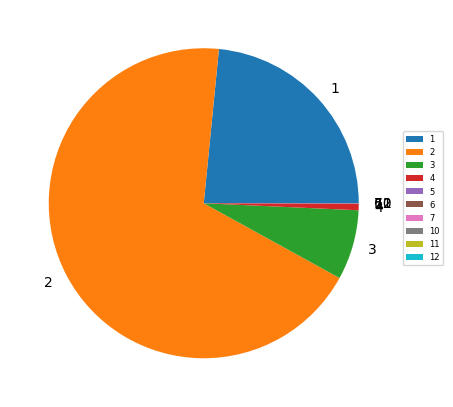

In [63]:
reactants = df['reactants'].apply(split_substances)
reactants_len = reactants.apply(lambda x: len(x))
# reactants_len.value_counts().sort_index() / len(reactants_len) * 100
pr = reactants_len.value_counts().sort_index()
fig = plt.figure(figsize=(5, 10))
plt.pie(pr,labels = pr.index)
plt.legend(loc="center right", bbox_to_anchor=(1,0.5), prop={'size': 6}, bbox_transform=plt.gcf().transFigure)
plt.show()

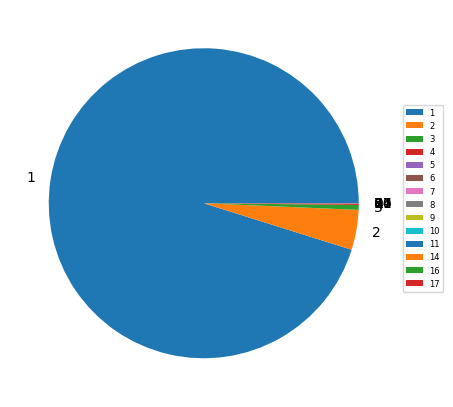

In [62]:
products = df['products'].apply(split_substances)
products_len = products.apply(lambda x: len(x))
pr = products_len.value_counts().sort_index()
fig = plt.figure(figsize=(5, 10))
plt.pie(pr,labels = pr.index)
plt.legend(loc="center right", bbox_to_anchor=(1,0.5), prop={'size': 6}, bbox_transform=plt.gcf().transFigure)
plt.show()

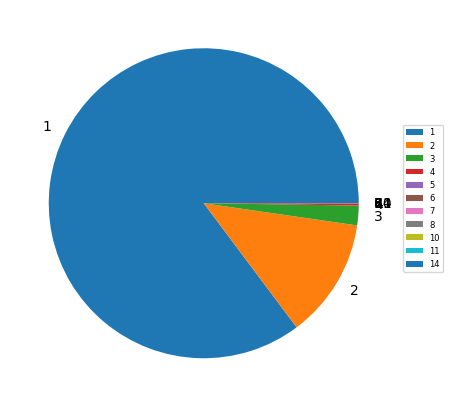

In [64]:
reagents = df['reagents_1'].apply(split_substances)
reagents_len = reagents.apply(lambda x: len(x))
# reagents_len.value_counts().sort_index() / len(reagents_len) * 100
pr = reagents_len.value_counts().sort_index()
fig = plt.figure(figsize=(5, 10))
plt.pie(pr,labels = pr.index)
plt.legend(loc="center right", bbox_to_anchor=(1,0.5), prop={'size': 6}, bbox_transform=plt.gcf().transFigure)
plt.show()

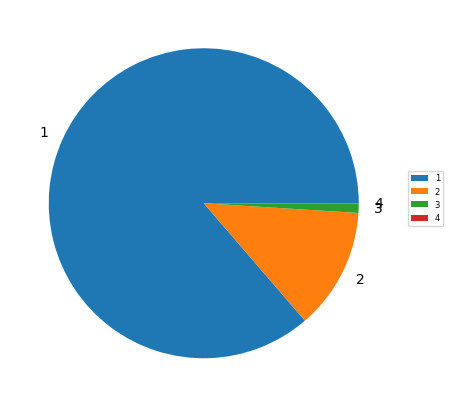

In [65]:
solvents = df['solvents_1'].apply(split_substances)
solvents_len = solvents.apply(lambda x: len(x))
# solvents_len.value_counts().sort_index() / len(solvents_len) * 100
pr = solvents_len.value_counts().sort_index()
fig = plt.figure(figsize=(5, 10))
plt.pie(pr,labels = pr.index)
plt.legend(loc="center right", bbox_to_anchor=(1,0.5), prop={'size': 6}, bbox_transform=plt.gcf().transFigure)
plt.show()

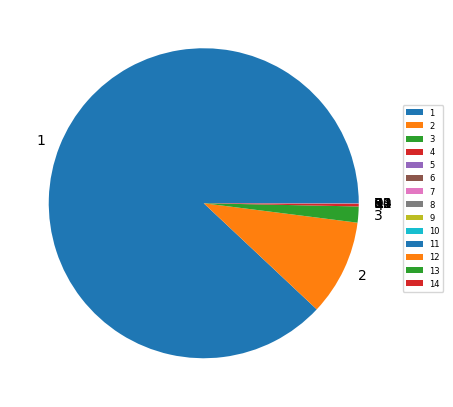

In [66]:
catalysts = df['catalysts_1'].apply(split_substances)
catalysts_len = catalysts.apply(lambda x: len(x))
# catalysts_len.value_counts().sort_index() / len(catalysts_len) * 100
pr = catalysts_len.value_counts().sort_index()
fig = plt.figure(figsize=(5, 10))
plt.pie(pr,labels = pr.index)
plt.legend(loc="center right", bbox_to_anchor=(1,0.5), prop={'size': 6}, bbox_transform=plt.gcf().transFigure)
plt.show()

In [18]:
f = df.shape
s = df[(reactants_len < 3) & (products_len == 1) & (reagents_len < 3) & (solvents_len < 3 ) & (catalysts_len < 3)].shape 
print((f[0] - s[0] - 318) / f[0] *100)

16.546562004032083


Разделение ячейки со списком веществ на разные столбцы

Удаление лишних символов из колонок с названиями веществ

In [671]:
def split_substances(substance):
    if substance is np.nan:
        return [np.nan, np.nan]
    else:
        try:
            substance = eval(substance)
        except SyntaxError:
            return [0, 0]
        if not substance:
            return [np.nan, np.nan]
        elif len(substance) == 1:
            return substance + [np.nan]
        elif len(substance) == 2:
            return substance
        else:
            return [0, 0]
        
    
columns_to_split = [
    'reagents_1',
    'solvents_1',
    'catalysts_1',
    'reactants',
    'products',
]

for column_name in columns_to_split:
    second_column_name = '{0}_II'.format(column_name)
    df[column_name], df[second_column_name] = zip(
        *df[column_name].apply(split_substances),
    )
    
df[columns_to_split + [i+'_II' for i in columns_to_split]]

C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\632063212.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name], df[second_column_name] = zip(
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\632063212.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name], df[second_column_name] = zip(
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\632063212.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

,reagents_1,solvents_1,catalysts_1,reactants,products,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II,products_II
0,Nitric acid,NaN,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
1,Pyridine,Water,NaN,119-53-9,134-81-6,Copper sulfate pentahydrate,NaN,NaN,NaN,NaN
2,Bismuth oxide (Bi2O3),Acetic acid,NaN,119-53-9,134-81-6,NaN,Glycol monoethyl ether,NaN,NaN,NaN
3,"Ethanol, thallium salt",Ethanol,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
4,Phenylseleninyl benzeneseleninate,Tetrahydrofuran,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
279756,NaN,Toluene,sec-Butyllithium,9011-14-7,106911-77-7,NaN,Cyclohexane,NaN,100-42-5,NaN
279757,NaN,Chloroform,NaN,9011-14-7,696598-57-9,NaN,NaN,NaN,100-42-5,NaN
279758,NaN,Toluene,Azobisisobutyronitrile,9011-14-7,696598-57-9,NaN,NaN,NaN,100-42-5,NaN
279759,NaN,NaN,NaN,9011-14-7,821787-83-1,NaN,NaN,NaN,100-42-5,NaN


Удаляем все реакции, где больше одного продукта и более 2х соединений в других участвующих веществах.

In [672]:
df = df[df['products_II'].isna()]

In [673]:
mask = (df['reagents_1'] != 0) & (df['solvents_1'] != 0) & (df['catalysts_1'] != 0) & (df['reactants'] != 0)
df = df[mask]

In [674]:
df

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,...,file,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II,products_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",Nitric acid,NaN,...,NaN,[],[],[],[],NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7",Pyridine,NaN,...,NaN,[],[],[],[],Copper sulfate pentahydrate,NaN,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",Bismuth oxide (Bi2O3),NaN,...,NaN,[],[],[],[],NaN,Glycol monoethyl ether,NaN,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","Ethanol, thallium salt",NaN,...,NaN,[],[],[],[],NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",Phenylseleninyl benzeneseleninate,NaN,...,NaN,[],[],[],[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,9011-14-7,106911-77-7,1,100,"Block copolymer intermediate, block copolymer,...","Kou, Youki","World Intellectual Property Organization, WO20...",NaN,sec-Butyllithium,...,11328.tsv,[10.0],[],[3.0],[],NaN,Cyclohexane,NaN,100-42-5,NaN
279757,31-614-CAS-26051353,9011-14-7,696598-57-9,1,85,Tailored Synthesis of Structurally Defined Pol...,"Yamago, Shigeru",Journal of the American Chemical Society (2002...,NaN,NaN,...,11328.tsv,[100.0],[],[24.0],[],NaN,NaN,NaN,100-42-5,NaN
279758,31-614-CAS-26567521,9011-14-7,696598-57-9,1,85,Silsesquioxane-cored miktoarm copolymer amphip...,"Gao, Shuxi","European Polymer Journal (2021), 143, 110196",NaN,Azobisisobutyronitrile,...,11328.tsv,[70.0],[],[2.0],[],NaN,NaN,NaN,100-42-5,NaN
279759,31-614-CAS-30155371,9011-14-7,821787-83-1,1,100,Precise Synthesis of New Triblock Co- and Terp...,"Matsuo, Yuri","Macromolecular Symposia (2013), 323(1), 26-36",NaN,NaN,...,11328.tsv,[-40.0],[],[20.0],[],NaN,NaN,NaN,100-42-5,NaN


In [675]:
# Получение списка растворителей, для которых надо знать reflux, замена reflux на температуры кипения
def replace_reflux(reaction, mapping):
    if reaction['temperature_1'] is np.nan:
        return reaction
    if 'reflux' not in reaction['temperature_1']:
        return reaction
    
    solvent_1 = reaction['solvents_1']
    solvent_2 = reaction['solvents_1_II']
    
    if solvent_1 is not np.nan:
        solvent_1 = solvent_1.lower()
        if solvent_1 in mapping:
            reaction['temperature_1'][0] = mapping[solvent_1]
    if solvent_2 is not np.nan:
        solvent_2 = solvent_2.lower()
        if solvent_2 in mapping:
            if mapping[solvent_2] < reaction['temperature_1'][0]:
                reaction['temperature_1'][0] = mapping[solvent_2]
        
    return reaction

reflux_df = df[df['temperature_1'].apply(lambda x: 'reflux' in x)]
reflux_solvents = set(reflux_df['solvents_1']).union(
    set(reflux_df['solvents_1_II']),
)
reflux_solvents.remove(np.nan)

boiling_points = pd.read_csv('../data/raw/boiling_points.csv', delimiter=';')
boiling_mapping = dict(
    zip(
        boiling_points['Solvent'],
        boiling_points['Boiling Point (Celsius)'],
    ),
)

mask =df.temperature_1.apply(lambda x: 'reflux' in x)
print("Before:\n\n", df[mask]['temperature_1'])
replace_reflux = partial(replace_reflux, mapping=boiling_mapping)

df = df.apply(replace_reflux, axis=1)

print("\n\nAfter:\n\n", df[mask]['temperature_1'])

Before:

 127       [reflux]
145       [reflux]
151       [reflux]
152       [reflux]
153       [reflux]
            ...   
279409    [reflux]
279535    [reflux]
279584    [reflux]
279587    [reflux]
279594    [reflux]
Name: temperature_1, Length: 25878, dtype: object


After:

 127        [68.7]
145        [81.6]
151        [39.8]
152        [83.5]
153       [110.6]
           ...   
279409      [100]
279535      [100]
279584    [110.6]
279587     [83.5]
279594     [83.5]
Name: temperature_1, Length: 25878, dtype: object


In [678]:
mask1 = df.temperature_1.apply(lambda x: 'cooled' in x)
mask2 = df.temperature_1.apply(lambda x: 'heated' in x)
mask3 = df.temperature_1.apply(lambda x: 'reflux' in x)
df[mask1 | mask2]

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,...,file,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II,products_II
228,31-480-CAS-20245,119-53-9,134-81-6,1,98,"Oxidation of 2-hydroxy-1,2-diarylethnone by Fe...","Xing, Chun-Yong","Youji Huaxue (2005), 25(1), 113-115",Iron chloride (FeCl3) (immobilized on montmori...,NaN,...,NaN,[heated],[],[0.16666666666666666],[],NaN,NaN,NaN,NaN,NaN
252,31-480-CAS-43175,119-53-9,134-81-6,1,52,Oxidation of benzylic alcohols to their corres...,"Hajipour, Abdol Reza","Synthetic Communications (2006), 36(17), 2563-...",Potassium periodate,Tetraethylammonium bromide,...,NaN,[heated],[],[0.1],[],NaN,NaN,NaN,NaN,NaN
319,31-480-CAS-34389,119-53-9,134-81-6,1,86,Synthesis of acyl carrier protein using a new ...,"Rajan, M. P.","Protein & Peptide Letters (2008), 15(10), 1068...",Nitric acid,NaN,...,NaN,[heated],[],[1.5],[],NaN,NaN,NaN,NaN,NaN
320,31-480-CAS-39391,119-53-9,134-81-6,1,81,The use of benzil to obtain functionalized N-h...,"Braibante, Mara E. F.",Journal of the Brazilian Chemical Society (200...,Ferric nitrate,NaN,...,NaN,[heated],[],[0.16666666666666666],[],NaN,NaN,NaN,NaN,NaN
321,31-480-CAS-22451,119-53-9,134-81-6,1,81,The use of benzil to obtain functionalized N-h...,"Braibante, Mara E. F.",Journal of the Brazilian Chemical Society (200...,Cupric nitrate,NaN,...,NaN,[heated],[],[0.05],[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277447,31-269-CAS-9512078,100-42-5,2425-28-7,1,20,Synthesis and properties of some aminothiols o...,"Guseinova, A. T.","Russian Journal of Applied Chemistry (2009), 8...",Bromine,NaN,...,NaN,[heated],[],[3.0],[],Potassium bromide,NaN,NaN,NaN,NaN
277575,31-177-CAS-20442381,955459-56-0,2363109-66-2,1,75,Synthesis and evaluation of anticancer propert...,"Yilmaz, Ulku","Inorganica Chimica Acta (2019), 495, 118977",Potassium carbonate,Triphenylphosphine,...,11365.tsv,[heated],[],[6.0],[],NaN,Water,Palladium diacetate,100-42-5,NaN
277898,31-177-CAS-8976652,100-42-5,22257-16-5,1,75,Microwave-promoted Heck reaction using Pd(OAc)...,"Du, Li-Hua","Synthetic Communications (2007), 37(2), 217-222",Alumina,Palladium diacetate,...,11362.tsv,[heated],[],[0.4166666666666667],[],Tripotassium phosphate,NaN,NaN,95-46-5,NaN
278388,31-177-CAS-13062465,100-42-5,20488-42-0,1,98,Microwave-promoted Heck reaction using Pd(OAc)...,"Du, Li-Hua","Synthetic Communications (2007), 37(2), 217-222",Alumina,Palladium diacetate,...,11384.tsv,[heated],[],[0.3333333333333333],[],Tripotassium phosphate,NaN,NaN,99-90-1,NaN


In [679]:
# Удаление непонятных слов
temperatures_to_delete = ['cooled', 'heated']
# temperatures_to_remove = ['reflux']
phs_to_remove = ['acidified', 'neutralized', 'basified']

mask1 = df.temperature_1.apply(lambda x: 'heated' in x)
mask2 = df.pH_1.apply(lambda x: 'acidified' in x)
print("Before:\n\n", df[mask1 & mask2][['temperature_1', 'pH_1']])

for temperature in temperatures_to_remove:
    mask1 = df['temperature_1'].apply(lambda x: temperature not in x)
    df = df[mask1]
    
for ph in phs_to_remove:
    df['pH_1'] = df['pH_1'].apply(lambda x: [] if ph in x else x)
    
df['temperature_1'] = df['temperature_1'].apply(lambda x: [] if 'reflux' in x else x)

mask1 = df.temperature_1.apply(lambda x: 'heated' in x)
mask2 = df.pH_1.apply(lambda x: 'acidified' in x)
print("\n\nAfter:\n\n", df[mask1 & mask2][['temperature_1', 'pH_1']])

Before:

       temperature_1         pH_1
42874      [heated]  [acidified]
43063      [heated]  [acidified]
43389      [heated]  [acidified]
43390      [heated]  [acidified]
43391      [heated]  [acidified]
43392      [heated]  [acidified]
43393      [heated]  [acidified]
43394      [heated]  [acidified]
43395      [heated]  [acidified]
43396      [heated]  [acidified]
52953      [heated]  [acidified]
52958      [heated]  [acidified]
53281      [heated]  [acidified]
54233      [heated]  [acidified]


After:

 Empty DataFrame
Columns: [temperature_1, pH_1]
Index: []


In [680]:
# Удаление дублирующейся температуры в пределах одной реакции
def drop_temperature_duplicates(temperature_list):
    if len(temperature_list) > 1:
        if temperature_list[0] == temperature_list[1] or temperature_list[1] == '':
            return [temperature_list[0]]
    return temperature_list
mask1 = df.temperature_1.str.len() > 1
print("Before:\n\n", df['temperature_1'][mask1])
df['temperature_1'] = df['temperature_1'].apply(drop_temperature_duplicates)
print("\n\nAfter:\n\n", df['temperature_1'][mask1])

Before:

 147       [25.0, ]
154       [25.0, ]
156       [25.0, ]
167       [25.0, ]
174       [25.0, ]
            ...   
279728    [25.0, ]
279730    [25.0, ]
279739    [25.0, ]
279754    [25.0, ]
279760    [25.0, ]
Name: temperature_1, Length: 57823, dtype: object


After:

 147       [25.0]
154       [25.0]
156       [25.0]
167       [25.0]
174       [25.0]
           ...  
279728    [25.0]
279730    [25.0]
279739    [25.0]
279754    [25.0]
279760    [25.0]
Name: temperature_1, Length: 57823, dtype: object


In [681]:
df = df.drop(['products_II'], axis=1)

In [682]:
def negative(x):
    if type(x) is list and len(x) > 0 and type(x[0]) == str:
        x[0] = x[0].replace('−', '-')
    return x

df['temperature_1'] = df['temperature_1'].apply(lambda x:  negative(x))
df['temperature_1'] = df['temperature_1'].apply(lambda x: float(x[0]) if len(x) > 0 else np.nan)
df[['pressure_1', 'time_1', 'pH_1']] = df[['pressure_1', 'time_1', 'pH_1']].applymap(lambda x: x[0] if len(x) > 0 else np.nan)

In [683]:
df

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,...,folder,file,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",Nitric acid,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7",Pyridine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",Bismuth oxide (Bi2O3),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","Ethanol, thallium salt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",Phenylseleninyl benzeneseleninate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,9011-14-7,106911-77-7,1,100,"Block copolymer intermediate, block copolymer,...","Kou, Youki","World Intellectual Property Organization, WO20...",NaN,sec-Butyllithium,...,11301-11400,11328.tsv,10.0,NaN,3.0,NaN,NaN,Cyclohexane,NaN,100-42-5
279757,31-614-CAS-26051353,9011-14-7,696598-57-9,1,85,Tailored Synthesis of Structurally Defined Pol...,"Yamago, Shigeru",Journal of the American Chemical Society (2002...,NaN,NaN,...,11301-11400,11328.tsv,100.0,NaN,24.0,NaN,NaN,NaN,NaN,100-42-5
279758,31-614-CAS-26567521,9011-14-7,696598-57-9,1,85,Silsesquioxane-cored miktoarm copolymer amphip...,"Gao, Shuxi","European Polymer Journal (2021), 143, 110196",NaN,Azobisisobutyronitrile,...,11301-11400,11328.tsv,70.0,NaN,2.0,NaN,NaN,NaN,NaN,100-42-5
279759,31-614-CAS-30155371,9011-14-7,821787-83-1,1,100,Precise Synthesis of New Triblock Co- and Terp...,"Matsuo, Yuri","Macromolecular Symposia (2013), 323(1), 26-36",NaN,NaN,...,11301-11400,11328.tsv,-40.0,NaN,20.0,NaN,NaN,NaN,NaN,100-42-5


#### Анализ предобработанных данных

In [503]:
df.describe()

,stages_number,yield_value,temperature_1,pressure_1
count,234017.0,234017.000000,187159.000000,8.887000e+03
mean,1.0,73.889662,58.031135,9.286813e+00
std,0.0,22.022833,50.108134,4.277957e+02
min,1.0,1.000000,-196.000000,1.330000e-10
25%,1.0,62.000000,25.000000,1.013300e-01
50%,1.0,80.000000,35.000000,6.000000e-01
75%,1.0,91.000000,90.000000,2.200000e+00
max,1.0,100.000000,1100.000000,4.000000e+04


In [684]:
# data = pd.read_csv("../data/interim/dataset_processed.csv", delimiter=';')
data = df.copy()

In [685]:
data.head()

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,...,folder,file,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",Nitric acid,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7",Pyridine,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",Bismuth oxide (Bi2O3),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","Ethanol, thallium salt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",Phenylseleninyl benzeneseleninate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [686]:
data[["reaction_id","reactants", "reactants_II","products"]][data[["reaction_id","reactants", "reactants_II","products"]].notnull().all(1)].sample(frac=1).head(10)

,reaction_id,reactants,reactants_II,products
238092,31-249-CAS-18369694,694-53-1,100-42-5,1123305-72-5
173902,31-008-CAS-18557622,135065-69-9,100-39-0,140695-92-7
278644,31-177-CAS-20165065,100-42-5,99-90-1,20488-42-0
182938,31-614-CAS-24322575,108-26-9,100-10-7,1346445-97-3
81156,31-130-CAS-17728504,1000623-95-9,57083-15-5,1402434-80-3
78509,31-031-CAS-6423937,425365-62-4,100-39-0,1440753-42-3
266458,31-368-CAS-16411157,329319-59-7,100-46-9,329319-63-3
258952,31-283-CAS-8689996,55962-05-5,100-42-5,24395-14-0
69392,31-265-CAS-21412084,108-24-7,88-72-2,6345-63-7
180715,31-316-CAS-232243,1169880-48-1,100-28-7,1383275-05-5


Уберем данные, которые для модели нам не нужны, только для истории.

In [687]:
data = data.drop(['reference_title', 'authors', 'bibliography', 'folder', 'file', 'other_conditions_1'], axis=1)

In [688]:
data.head()

,reaction_id,reactants,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Pyridine,NaN,Water,NaN,NaN,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Посмотрим пропуски в данных в %

In [544]:
data.isna().sum() / data.shape[0] * 100

reaction_id        0.000000
reactants          0.000000
products           0.000000
stages_number      0.000000
yield_value        0.000000
reagents_1        29.075665
catalysts_1       54.631501
solvents_1        14.493392
temperature_1     20.023332
pressure_1        96.202413
time_1            33.941979
pH_1              99.467560
reagents_1_II     84.051586
solvents_1_II     86.192456
catalysts_1_II    87.291949
reactants_II      25.228082
dtype: float64

Пропуски для второго реактанта является нормой, реакции могут протекать с одним веществом или несколькими. 

Реагенты, катализаторы и солвенты - необязательные для реакции, любые пропуски для них тоже норма. 

Пропуски по температуре обычно обусловлены либо "забывчивостью" автора источника, либо проблемой перевода источника в базу данных, либо то, что условия реакции протекают при нормальных условиях, а числа просто не указаны. 

Пропуски по давлению имеет те же причины, что и пропуски по температуре, с уточнением, что большинство реакций, изученных человеком, проходят при атмосферном давлении.

In [545]:
# data['temperature_1'] = data['temperature_1'].fillna(20.0)

#### Проверим числовые признаки. Сначала посмотрим на самый важный признак выход продукта

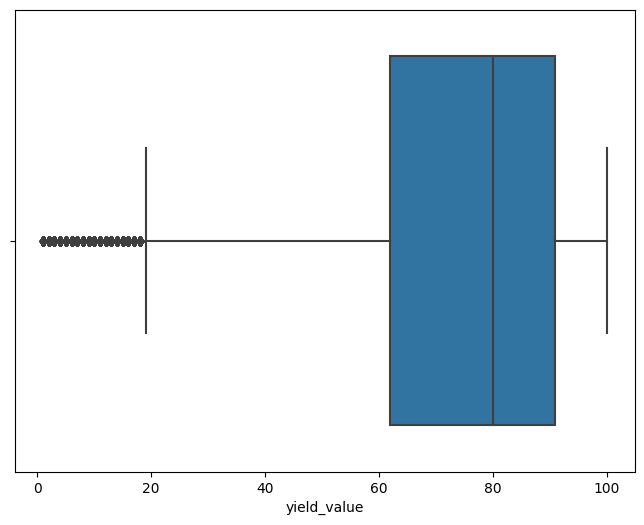

In [546]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["yield_value"])
plt.show()

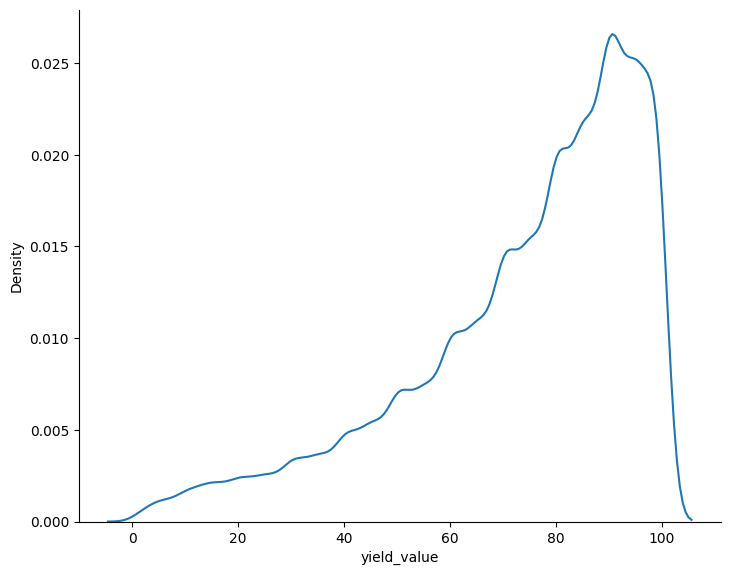

In [547]:
g = sns.displot(x=data["yield_value"], kind="kde")
g.fig.set_size_inches(8,6)

In [548]:
print("Min: ", data["yield_value"].min(), "\nMax: ", data["yield_value"].max(), "\nMedian: ", '{:.2f}'.format(data["yield_value"].mean()))

Min:  1 
Max:  100 
Median:  73.89


#### Температура, цельсии

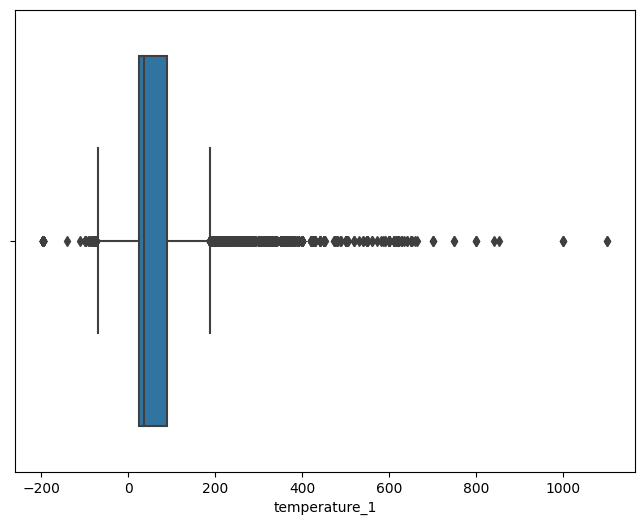

In [549]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["temperature_1"])
plt.show()

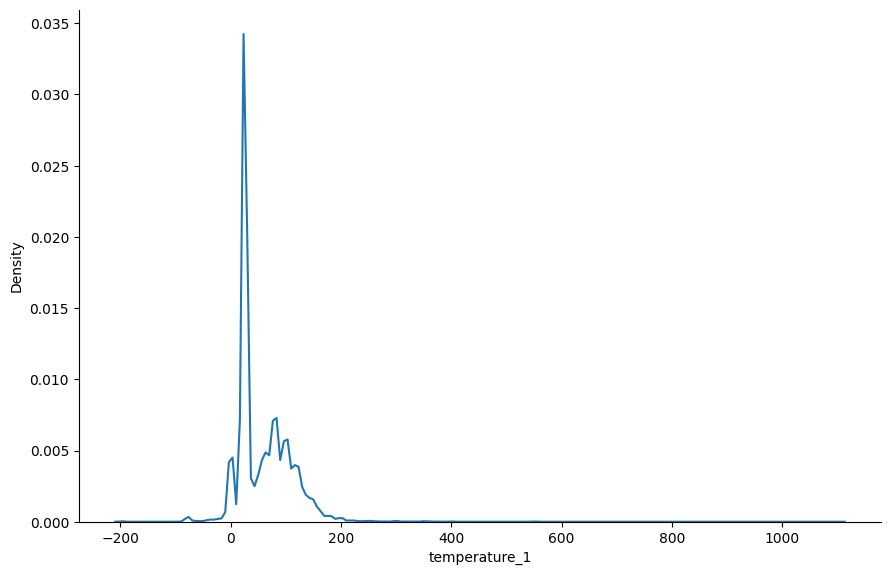

In [550]:
g = sns.displot(x=data["temperature_1"], kind="kde")
g.fig.set_size_inches(10,6)

In [689]:
# - 100 ... 300
mask = (data["temperature_1"] < -100) | (data["temperature_1"] > 300)
data = data[~mask]

In [690]:
data

,reaction_id,reactants,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Pyridine,NaN,Water,NaN,NaN,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,9011-14-7,106911-77-7,1,100,NaN,sec-Butyllithium,Toluene,10.0,NaN,3.0,NaN,NaN,Cyclohexane,NaN,100-42-5
279757,31-614-CAS-26051353,9011-14-7,696598-57-9,1,85,NaN,NaN,Chloroform,100.0,NaN,24.0,NaN,NaN,NaN,NaN,100-42-5
279758,31-614-CAS-26567521,9011-14-7,696598-57-9,1,85,NaN,Azobisisobutyronitrile,Toluene,70.0,NaN,2.0,NaN,NaN,NaN,NaN,100-42-5
279759,31-614-CAS-30155371,9011-14-7,821787-83-1,1,100,NaN,NaN,NaN,-40.0,NaN,20.0,NaN,NaN,NaN,NaN,100-42-5


In [563]:
print("Min: ", data["temperature_1"].min(), "\nMax: ", data["temperature_1"].max(), "\nMean: ", '{:.2f}'.format(data["temperature_1"].mean()), "\nMedian: ", '{:.2f}'.format(data["temperature_1"].median()))

Min:  -100.0 
Max:  300.0 
Mean:  57.22 
Median:  35.00


#### Давление, МПа

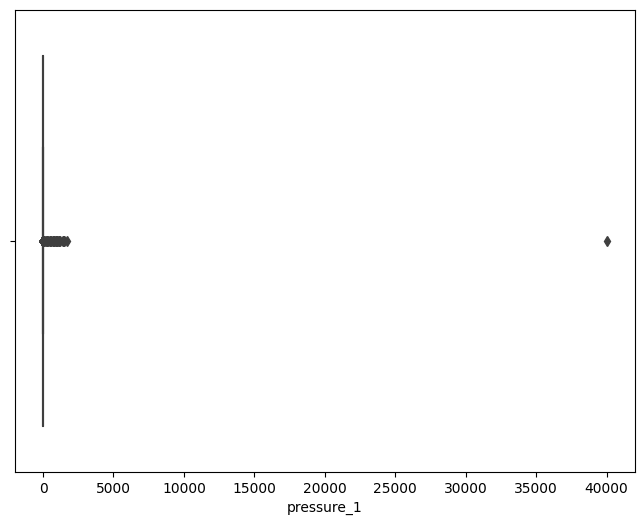

In [564]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["pressure_1"])
plt.show()

In [575]:
data.query("pressure_1 == 40000").index

Int64Index([4721], dtype='int64')

In [691]:
data = data.drop(data.query("pressure_1 == 40000").index, axis=0)

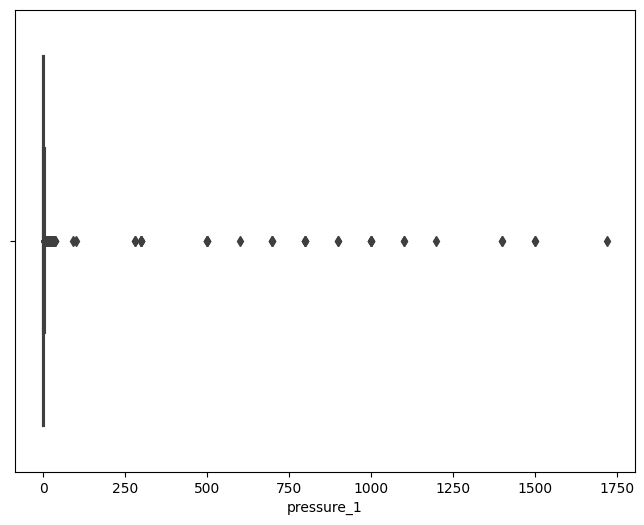

In [577]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["pressure_1"])
plt.show()

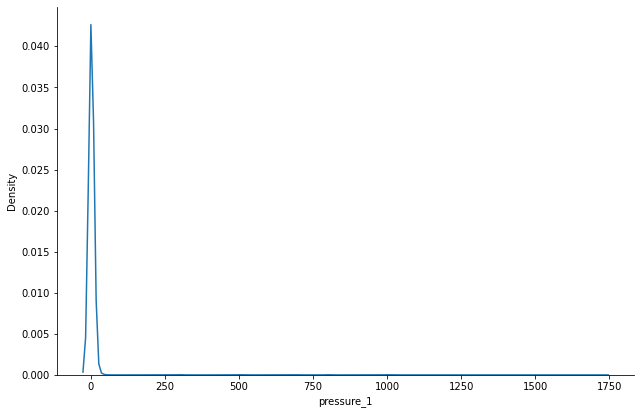

In [63]:
g = sns.displot(x=data["pressure_1"], kind="kde")
g.fig.set_size_inches(10,6)

In [521]:
# сколько данных с P>< normal 
data.pressure_1.value_counts()

0.101330    2055
1.000000     724
2.000000     557
3.000000     464
0.100000     456
            ... 
3.651700       1
0.008645       1
0.017689       1
2.050000       1
3.242560       1
Name: pressure_1, Length: 416, dtype: int64

In [692]:
# 0.1 ... 10
mask = (data["pressure_1"] < 0.1) | (data["pressure_1"] > 10)
data = data[~mask]

In [693]:
data

,reaction_id,reactants,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,time_1,pH_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Pyridine,NaN,Water,NaN,NaN,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,9011-14-7,106911-77-7,1,100,NaN,sec-Butyllithium,Toluene,10.0,NaN,3.0,NaN,NaN,Cyclohexane,NaN,100-42-5
279757,31-614-CAS-26051353,9011-14-7,696598-57-9,1,85,NaN,NaN,Chloroform,100.0,NaN,24.0,NaN,NaN,NaN,NaN,100-42-5
279758,31-614-CAS-26567521,9011-14-7,696598-57-9,1,85,NaN,Azobisisobutyronitrile,Toluene,70.0,NaN,2.0,NaN,NaN,NaN,NaN,100-42-5
279759,31-614-CAS-30155371,9011-14-7,821787-83-1,1,100,NaN,NaN,NaN,-40.0,NaN,20.0,NaN,NaN,NaN,NaN,100-42-5


In [580]:
print("Min: ", data["pressure_1"].min(), "\nMax: ", data["pressure_1"].max(), "\nMean: ", '{:.2f}'.format(data["pressure_1"].mean()), "\nMedian: ", '{:.2f}'.format(data["pressure_1"].median()))

Min:  0.1 
Max:  10.0 
Mean:  1.53 
Median:  0.61


In [694]:
data = data.drop(['time_1', 'pH_1'], axis=1)
data.to_csv('data_processed_clean.csv', index=False)

In [695]:
data

,reaction_id,reactants,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II
0,31-480-CAS-24139,119-53-9,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,134-81-6,1,86,Pyridine,NaN,Water,NaN,NaN,Copper sulfate pentahydrate,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,134-81-6,1,95,Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN,Glycol monoethyl ether,NaN,NaN
3,31-480-CAS-25495,119-53-9,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279756,31-614-CAS-26952067,9011-14-7,106911-77-7,1,100,NaN,sec-Butyllithium,Toluene,10.0,NaN,NaN,Cyclohexane,NaN,100-42-5
279757,31-614-CAS-26051353,9011-14-7,696598-57-9,1,85,NaN,NaN,Chloroform,100.0,NaN,NaN,NaN,NaN,100-42-5
279758,31-614-CAS-26567521,9011-14-7,696598-57-9,1,85,NaN,Azobisisobutyronitrile,Toluene,70.0,NaN,NaN,NaN,NaN,100-42-5
279759,31-614-CAS-30155371,9011-14-7,821787-83-1,1,100,NaN,NaN,NaN,-40.0,NaN,NaN,NaN,NaN,100-42-5


#### Перевод из CAS в SMILES

Универсальным вариантом цифрового представления химических соединений является формат SMILES. Данный формат гибок, поскольку из него возможен перевод во многие другие представления. Есть SMILES канонический и изометрический. Конечно, полностью учесть любой вид изомерии невозможно на данный момент, но частично все же можно.

In [8]:
# Выделяются уникальные значения CAS номеров
cas = pd.unique(data[["reaction_id","reactants", "reactants_II","products"]].values.ravel('K'))
cas

array(['31-480-CAS-24139', '31-480-CAS-18071', '31-480-CAS-27637', ...,
       '1430108-69-2', '290827-82-6', '661451-78-1'], dtype=object)

In [9]:
# Часть нашли с помощью библиотеки
def cas_to_smiles(x):
    smiles = cirpy.resolve(x,'smiles')
    return smiles
smiles = [cas_to_smiles(x) for x in cas[261900:261910]]
smiles

[None,
 'OC1CCCCC1',
 'O=C1CCCCC1',
 'Oc1ccccc1',
 'Sc1ccccc1',
 'Nc1ncccn1',
 None,
 None,
 None,
 None]

In [174]:
# Часть искали в SciFinder
df_cas = pd.read_csv('../data/raw/products_smiles.csv', index_col=None)
df_cas.head()

,query,result,comment
0,132330-98-4,BrC1=NC=CC=C1OCC=2C=CC=CC2,NaN
1,121090-71-9,S1C=2C=CC=CC2SC3=C1C(=CC=C3C(C)C)C(C)C,NaN
2,1071126-38-9,C=1C=CC(=CC1)C2=C(C=3NC=4C=CC=CC4C3CC2)CC,NaN
3,1351653-66-1,O=CN(C)C.O=C([O-])C=1C=CC(=CC1)C2=O[Cd+2]([O-]...,NaN
4,1821197-17-4,[Br-].O=C(NC(CC=1C=CC=CC1)C[P+](C=2C=CC=CC2)(C...,NaN


In [ ]:
# Часть нашли вручную
k = {
    '1H-Imidazolium, 3-dodecyl-1-methyl-, (T-4)-tetrachloroferrate(1-) (1:1)':'[Cl-][Fe+3]([Cl-])([Cl-])[Cl-].C1=C[N+](=CN1C)CCCCCCCCCCCC',
    '(±)-2-Butanol':'OC(C)CC',
    'N,N,N′,N′-Tetramethylethylenediamine':'N(C)(C)CCN(C)C',
    '(1S,5R)-6,8-Dioxabicyclo3.2.1octan-4-one':'O=C1CCC2OC1OC2',
    '(5β,7α,12β)-7,12-Dihydroxycholan-24-oic acid':'O=C(O)CCC(C)C1CCC2C3C(O)CC4CCCCC4(C)C3CC(O)C12C',
    '(T-4)-N,N-Dibutyl-N-2-(hydroxy-κO)ethyl-1-butanaminiumatotrihydroboron':'[H-][B+3]([H-])([H-])[O-]CC[N+](CCCC)(CCCC)CCCC',
    '(±)-2-Hexanol':'OC(C)CCCC',
    '(±)-Propylene glycol':'OCC(O)C',
    '(±)-Propylene oxide':'O1CC1C',
    '1,1′-Biphenyl, mixt. with 1,1′-oxybisbenzene':'C=1C=CC(=CC1)C=2C=CC=CC2',
    '1-3,5-Diiodo-4-(4-methoxyphenoxy)phenylethanone':'O=C(C1=CC(I)=C(OC2=CC=C(OC)C=C2)C(I)=C1)C',
    '1-Butanaminium, 4-bis(2-hydroxyethyl)amino-N,N,N-tributyl-, bromide (1:1)':'[Br-].OCCN(CCO)CCCC[N+](CCCC)(CCCC)CCCC',
    '1-Propene, 1,1,2,3,3,3-hexafluoro-, trimer':'FC(F)=C(F)C(F)(F)F',
    '1H-Imidazolium, 1,3-dimethyl-, methanesulfonate (1:1)':'O=S(=O)([O-])C.C1=C[N+](=CN1C)C',
    '1H-Imidazolium, 1-ethyl-3-methyl-, chloride, μ-chlorotetrachlorodizincate(1-)':'[Cl-].[Cl-][Zn+2]([Cl-])[Cl-][Zn+2]([Cl-])[Cl-].C1=C[N+](=CN1C)CC',
    '1H-Imidazolium, 3,3′-(1,4-butanediyl)bis1-methyl-, bromide (1:2)':'[Br-].C1=C[N+](=CN1C)CCCC[N+]=2C=CN(C2)C',
    '1H-Imidazolium, 3-hexyl-1-methyl-, 2,2,2-trifluoroacetate (1:1)':'O=C([O-])C(F)(F)F.C1=C[N+](=CN1C)CCCCCC',
    '3,4-Dihydro-2H-pyran':'O1C=CCCC1',
    '4′-Methoxyacetophenone':'O=C(C1=CC=C(OC)C=C1)C',
    '5-(1,1-Dimethylethoxy)(4-nitrophenyl)methyl-2,4(1H,3H)-pyrimidinedione':'O=C1NC=C(C(=O)N1)C(OC(C)(C)C)C2=CC=C(C=C2)N(=O)=O',
    'Benzo2,3cholest-2-en-4′-ol':'OC1=CC=C2C(=C1)CC3CCC4C5CCC(C(C)CCCC(C)C)C5(C)CCC4C3(C)C2',
    'Ethanaminium, 2-hydroxy-N,N,N-trimethyl-, μ-chlorotetrachlorodizincate(1-) (1:1)':'[Cl-][Zn+2]([Cl-])[Cl-][Zn+2]([Cl-])[Cl-].OCC[N+](C)(C)C',
    'Formic acid, compd. with 2-(2-aminoethyl)aminoethanol (1:1)':'O=CO.OCCNCCN',
    'Guanidine, 2,2,2-trifluoroacetate (1:1)':'O=C(O)C(F)(F)F.N=C(N)N',
    'Guanidine, N,N,N′,N′-tetramethyl-, 2,2,2-trifluoroacetate (1:1)':'O=C(O)C(F)(F)F.N=C(N(C)C)N(C)C',
    'N,N′-Dimethylurea':'O=C(NC)NC',
    'N-7-(4-Amino-2,3-dihydroxybutyl)-6,7-dihydro-6-oxo-1H-purin-2-ylacetamide':'O=C1N=C(NC(=O)C)NC=2N=CN(C12)CC(O)C(O)CN',
    'Thiophene, 2,5-dihydro-2-methyl-, 1,1-dioxide':'O=S1(=O)CC=CC1C',
    'α,α-Bis(trifluoromethyl)benzenemethanol':'FC(F)(F)C(O)(C=1C=CC=CC1)C(F)(F)F',
    'β-Cyclodextrin':'OCC1OC2OC3C(O)C(O)C(OC3CO)OC4C(O)C(O)C(OC4CO)OC5C(O)C(O)C(OC5CO)OC6C(O)C(O)C(OC6CO)OC7C(O)C(O)C(OC7CO)OC8C(O)C(O)C(OC8CO)OC1C(O)C2O',
    'β-D-Glucopyranoside, methyl, 2,3-bis(4-methylbenzenesulfonate)':'O=S(=O)(OC1C(OC)OC(CO)C(O)C1OS(=O)(=O)C2=CC=C(C=C2)C)C3=CC=C(C=C3)C',
    'γ-Butyrolactone':'O=C1OCCC1',
    'γ-Valerolactone':'O=C1OC(C)CC1',
    'Toluene (α-bromo or α-chloro derivative)':'C=1C=CC(=CC1)C',
    'Pyridinium, 1,1′-(1,6-hexanediyl)bis3-methyl-, bromide (1:2)':'[Br-].C=1C=C(C=[N+](C1)CCCCCC[N+]=2C=CC=C(C2)C)C',
    None:None
}

#### Получение fingerprints из SMILES

Если вы решили работать с fingerprint в качестве дескриптора, то вам нужно выбрать параметр радиуса и nBits. Радиус определеяется размером охватываемых связей, для выбора этого параметра, лучше ознакомится со стуктурой fingerprint. А nBits это размер вектора, который вы хотите получить. Его стоит регулировать относительно размера датасета. 

In [163]:
smiles = df_cas['result'][20:30]
smiles

20    [N-]=[N+]=NC1C(OCC=2C=CC=CC2)C(OCC=3C=CC=CC3)O...
21                            N=1C(=CSC1C=2C=CC=CC2)C=C
22     O=C1OC(OC(=O)C1(CC=2C=CC=CC2)CC=3C=CC=CC3OC)(C)C
23        FC1(F)C(O)C=CC1C(OCC=2C=CC=CC2)COCC=3C=CC=CC3
24                    S=C1NN=C(N1)C=2C=CC(=CC2)C(C)(C)C
25    O=C(OC)N(C(=O)C(C=CC(C(=O)OC)CC=1C=CC=CC1)CC=2...
26    O=C(OC)C1=C(NC(=O)N(CC2=CC=C(F)C=C2)C1CC(=O)NC...
27      O=C(OCC)C1=C(SC2=C(C=NCC=3C=CC=CC3)C(=NN21)C)SC
28    ClC1=NN=C(N=NC(CCC=2C=CC=CC2)C(C=C)C=3C=CC=CC3...
29    N=1C(=NC2=CC=CC(OC3=CC=CC(OC)=C3)=C2C1N)NCC=4C...
Name: result, dtype: object

In [161]:
def get_fingerprint(x, nBits):
    fp_array = np.zeros((0,), dtype=np.int8)
    if x is not None and type(x) != float:
        mol = Chem.MolFromSmiles(x)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits) 
        ConvertToNumpyArray(fp, fp_array)
        return fp_array
    else:
        return np.zeros((nBits,), dtype=np.int8)

In [164]:
cas = smiles.apply(get_fingerprint, nBits=128).to_frame()
cas

,result
20,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
21,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, ..."
22,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
23,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, ..."
24,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
25,"[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
26,"[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
27,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
28,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
29,"[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..."


Создание фингерпринтов помогает отловить ошибки в соедниениях:

In [175]:
smiles = df_cas['result'][0:5]
cas = smiles.apply(get_fingerprint, nBits=128).to_frame()
cas

[19:03:15] Explicit valence for atom # 15 O, 3, is greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

Начало ошибки четко сигнализирует в чем проблема: *Explicit valence for atom # 15 O, 3, is greater than permitted*.

#### Обработка растворителей и катализаторов

Основная задача подготовки данных для данного проекта - сделать так, чтобы модель смогла научиться понимать и различать химическую информацию в приближенной к человеку манере. Для этого помимо структуры молекул необходимо сообщить модели информацию о химических свойствах некоторых классов веществ, таких как растворители и катализаторы.
Свойства растворителей в основном определяются так называемыми сольватационными параметрами. [Minnesota Solvent Descriptor Database](https://comp.chem.umn.edu/solvation/mnsddb.pdf) - база данных университета Миннесоты, содержащая в себе информацию о параметрах около 180 растворителей, включая такие физические и химические константы как: показатель преломления оптических частот, параметры Абрахама, поверхностное натяжение, ароматичность, диэлектрическая постоянная и др. Недостатком этой базы данных является неудобный формат pdf, который необходимо перевести в цифровой вид.

Наиболее важным параметром катализатора является его активность, которая может быть определена по энергии поглощения. В базе данных [Catalyst Property Database](https://cpd.chemcatbio.org/) собрана информация об энергиях поглощения поверхностных частиц более чем 1000 катализаторов. База данных постоянно обновляется.

In [ ]:
# таблица растворителей
# таблица катализаторам (?)

## Выделение информации из веществ с помощью [RDkit](https://rdkit.org/)

Помимо специфических параметров растворителей и катализаторов можно рассчитать более универсальные дескрипторы с помощью библиотеки RDKit.

In [26]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)O')
print('Heavy atoms count:', Descriptors.HeavyAtomCount(m)) #количество тяжелых атомов в молекуле, может быть полезно для описания катализаторов, в состав которых входят тяжелые металлы
print('Surface area:',Descriptors.LabuteASA(m)) #площадь поверхности, может быть полезна для описания реакционной способности катализатора.
print('Number of H donors:', Descriptors.NumHDonors(m))
print('Number of H acceptors:', Descriptors.NumHAcceptors(m)) #количество доноров или акцепторов водородной связи, по которым можно определить силу растворителя

Heavy atoms count: 9
Surface area: 52.75210108613335
Number of H donors: 1
Number of H acceptors: 1


Оптимизировать 3д структуру молекулы из мол файла Chem.MolFromSmiles, получить графы из молфайла, делать из оптимизированного

In [ ]:
1. Сначала структуру возьмем (комбинация фигнерпринты+графы/ графы+смайлз)
2. Если что добавим дескрипторы

## Работа с графовым представлением реакций с помощью [CGRTools](https://cgrtools.readthedocs.io/)

Библиотека CGRTools позволяет работать с особым видом предстваления реакций - конденсированным графом реакции (Condensed Graph of Recation). Данный формат представляет собой псевдо-молекулу, состоящую из статических (обычных) связей и динамических (образующихся в ходе реакции) связей. CGRTools позволяет преобразовывать различные форматы представления молекул в конденсированные графы происходящих с ними реакций.

In [19]:
m1 = SMILESRead(io.StringIO('BrC1=CC=C(C=C1)N(=O)=O>>NC1=CC(Br)=CC=C1N(=O)=O')).read()
cgr = m1[0].compose()
print(cgr)
type(cgr)

O=N(=O)C=1C=CC(=CC=1)Br.O=N(=O)C2=CC=C(C=C2N)Br


CGRtools.containers.cgr.CGRContainer

## Кластеризация

In [3]:
all_df = pd.read_csv('../data/raw/датасет 4000 реакций (с первых 100 страниц SF).csv', delimiter=';')

In [4]:
all_df['reactants_smiles'] = all_df['reactants_smiles'].apply(lambda x: None if 'None' in x else x) 
all_df['products_smiles'] = all_df['products_smiles'].apply(lambda x: None if 'None' in x else x) 
all_df = all_df.query('reactants_smiles == reactants_smiles & products_smiles == products_smiles')

In [5]:
all_df = all_df.reset_index(drop=True)
all_df.head()

,reaction_id,stages_number,yield_value,reactants,products,title,authors,bibliography,other_conditions_1,temperature,...,catalysts_1,catalysts_1_2,solvents_1,other_conditions_2,reagents_2,catalysts_2,solvents_2,solvents_1_2,reactants_smiles,products_smiles
0,31-614-CAS-26539186,1,100.0,110-54-3,74-82-8,Dehydrocyclization of n-hexane over heteropoly...,"Eid, Abdellah",Advances in Chemical Engineering and Science (...,400 °C,400.0,...,2245045-74-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C
1,31-614-CAS-28519743,1,96.0,110-54-3,74-82-8,Hierarchical H-ZSM-5-supported cobalt for the ...,"Sartipi, Sina","Journal of Catalysis (2013), 305, 179-190","15 bar, 493 K",220.0,...,Cobalt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C
2,31-614-CAS-30341229,2,93.0,110-54-3,74-82-8,Different Catalytic Reactions of n-Hexane and ...,"Al-Kharafi, F.","Catalysis Letters (2008), 123(3-4), 269-275","24 h, 873 K",600.0,...,Molybdenum oxide (MoO3),NaN,NaN,873 K,Hydrogen,NaN,NaN,NaN,CCCCCC,C
3,31-614-CAS-30602615,1,100.0,112-80-1,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","10 h, rt → 360 °C",192.5,...,Rhodium,NaN,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCC/C=C/CCCCCCCC(O)=O,C
4,31-614-CAS-28368873,1,100.0,124-38-9,74-82-8,Accessing Two-Coordinate ZnII Organocations by...,"Specklin, David","Chemistry - A European Journal (2017), 23(63),...","1.5 bar, rt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C


In [6]:
all_df['reactants_smiles'] = all_df['reactants_smiles'].str.replace(' ; ', '.')
all_df['products_smiles'] = all_df['products_smiles'].str.replace(' ; ', '.')

In [7]:
all_df['reaction_smiles'] = all_df['reactants_smiles'] + '>>' + all_df['products_smiles']
all_df['reaction_smiles']

0                                   CCCCCC>>C
1                                   CCCCCC>>C
2                                   CCCCCC>>C
3               CCCCCCCC/C=C/CCCCCCCC(O)=O>>C
4                                    O=C=O>>C
                        ...                  
2771    OC(=O)c1ccccc1.C#C>>C=COC(=O)c1ccccc1
2772                      C=C.CCCCO>>CCCCOCCO
2773                CC(=O)C=C.C=C>>CCCCC(C)=O
2774           Cc1ccccc1O.C=C>>CCc1cccc(C)c1O
2775           Cc1ccccc1O.C=C>>CCc1cccc(C)c1O
Name: reaction_smiles, Length: 2776, dtype: object

In [10]:
#перевод в фингерпринты

# all_df['reaction_fingerprint'] = all_df['reaction_smiles'].apply(lambda x: DrfpEncoder.encode(x, n_folded_length=2048))
# all_df['reaction_fingerprint']

In [40]:
all_df = pd.read_csv('../data/interim/fingerprints_reactions.csv')
all_df

,reaction_id,stages_number,yield_value,reactants,products,title,authors,bibliography,other_conditions_1,temperature,...,solvents_1,other_conditions_2,reagents_2,catalysts_2,solvents_2,solvents_1_2,reactants_smiles,products_smiles,reaction_smiles,reaction_fingerprint
0,31-614-CAS-26539186,1,100.0,110-54-3,74-82-8,Dehydrocyclization of n-hexane over heteropoly...,"Eid, Abdellah",Advances in Chemical Engineering and Science (...,400 °C,400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C,CCCCCC>>C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,31-614-CAS-28519743,1,96.0,110-54-3,74-82-8,Hierarchical H-ZSM-5-supported cobalt for the ...,"Sartipi, Sina","Journal of Catalysis (2013), 305, 179-190","15 bar, 493 K",220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,CCCCCC,C,CCCCCC>>C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,31-614-CAS-30341229,2,93.0,110-54-3,74-82-8,Different Catalytic Reactions of n-Hexane and ...,"Al-Kharafi, F.","Catalysis Letters (2008), 123(3-4), 269-275","24 h, 873 K",600.0,...,NaN,873 K,Hydrogen,NaN,NaN,NaN,CCCCCC,C,CCCCCC>>C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,31-614-CAS-30602615,1,100.0,112-80-1,74-82-8,Preparation method of methane by fatty acid hy...,"Zhang, Jing","China, CN109776248 A 2019-05-21","10 h, rt → 360 °C",192.5,...,Water,NaN,NaN,NaN,NaN,NaN,CCCCCCCC/C=C/CCCCCCCC(O)=O,C,CCCCCCCC/C=C/CCCCCCCC(O)=O>>C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,31-614-CAS-28368873,1,100.0,124-38-9,74-82-8,Accessing Two-Coordinate ZnII Organocations by...,"Specklin, David","Chemistry - A European Journal (2017), 23(63),...","1.5 bar, rt",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,O=C=O,C,O=C=O>>C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2771,31-237-CAS-15656792,1,52.0,65-85-0.74-86-2,769-78-8,Atom-economic catalytic amide synthesis from a...,"Krause, Thilo","Nature Communications (2016), 7, 11732pp.","8 h, 80 °C",80.0,...,"1,4-Dioxane",NaN,NaN,NaN,NaN,NaN,OC(=O)c1ccccc1.C#C,C=COC(=O)c1ccccc1,OC(=O)c1ccccc1.C#C>>C=COC(=O)c1ccccc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2772,31-614-CAS-30179694,1,99.0,74-85-1.71-36-3,111-76-2,Green one-step synthesis method of alcohol eth...,"Wang, Ping","China, CN107501053 A 2017-12-22",NaN,NaN,...,Water,NaN,NaN,NaN,NaN,NaN,C=C.CCCCO,CCCCOCCO,C=C.CCCCO>>CCCCOCCO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2773,31-614-CAS-25714458,1,99.0,78-94-4.74-85-1,591-78-6,Formation of carbon-carbon and carbon-heteroat...,"Negishi, Ei-Ichi","Organic Reactions (Hoboken, NJ, United States)...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CC(=O)C=C.C=C,CCCCC(C)=O,CC(=O)C=C.C=C>>CCCCC(C)=O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2774,31-085-CAS-5259889,1,99.0,95-48-7.74-85-1,1687-64-5,Halide-free ethylation of phenol by multifunct...,"Carrion, M. Carmen","Chemical Communications (Cambridge, United Kin...","15 h, 30 bar, 120 °C",120.0,...,Toluene,NaN,NaN,NaN,NaN,NaN,Cc1ccccc1O.C=C,CCc1cccc(C)c1O,Cc1ccccc1O.C=C>>CCc1cccc(C)c1O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
from ast import literal_eval

In [42]:
all_df['reaction_fingerprint'] = all_df['reaction_fingerprint'].apply(lambda x: literal_eval(x))

In [45]:
all_df['reaction_fingerprint'] = all_df['reaction_fingerprint'].apply(lambda x: np.array(x))

In [49]:
X = all_df['reaction_fingerprint'].values
X = np.stack(X)
X.shape

(2776, 2048)

In [51]:
distances = ['jaccard', 'rogerstanimoto', 'dice']
neighbors = [50, 100, 150]
min_dist = [0.0, 0.1, 0.3, 0.5]

In [55]:
from itertools import product

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


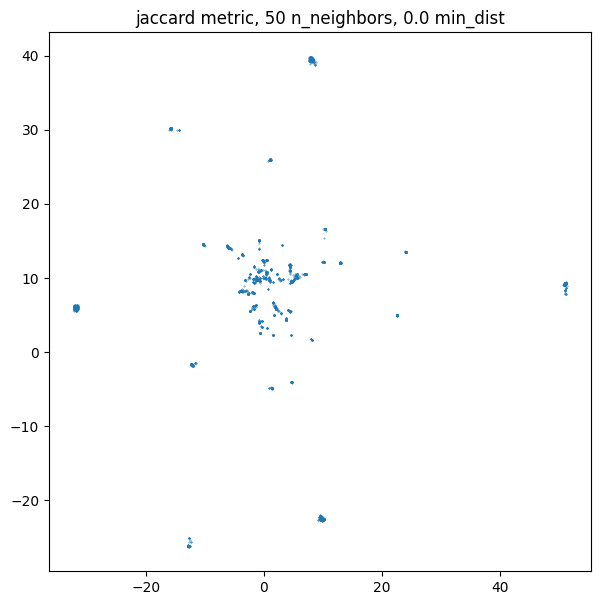

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


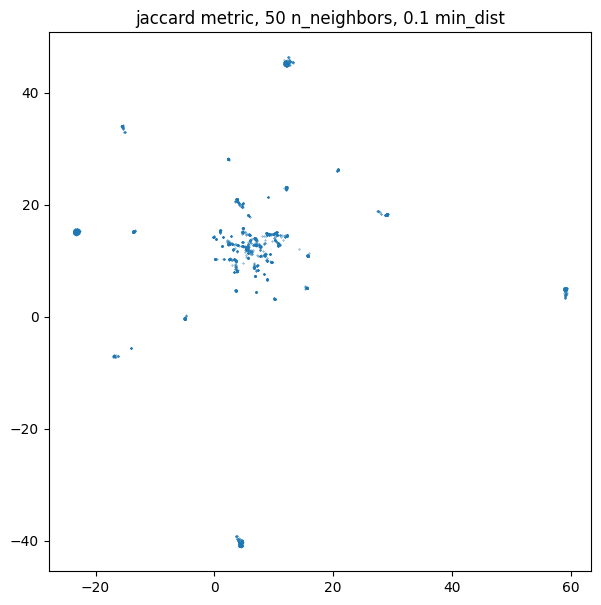

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


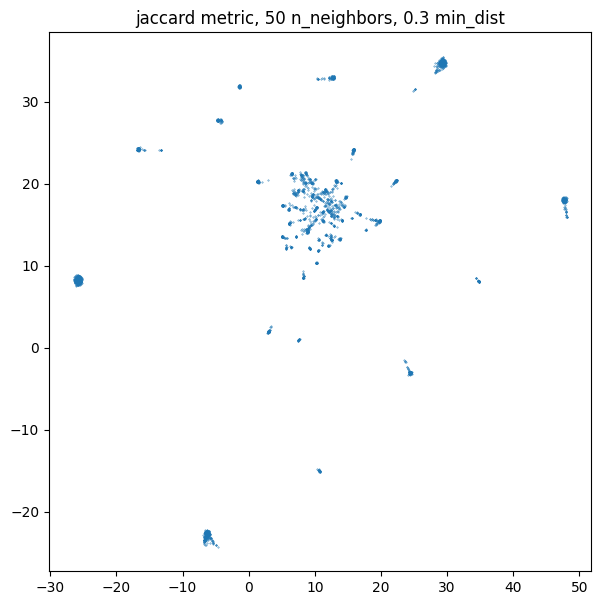

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


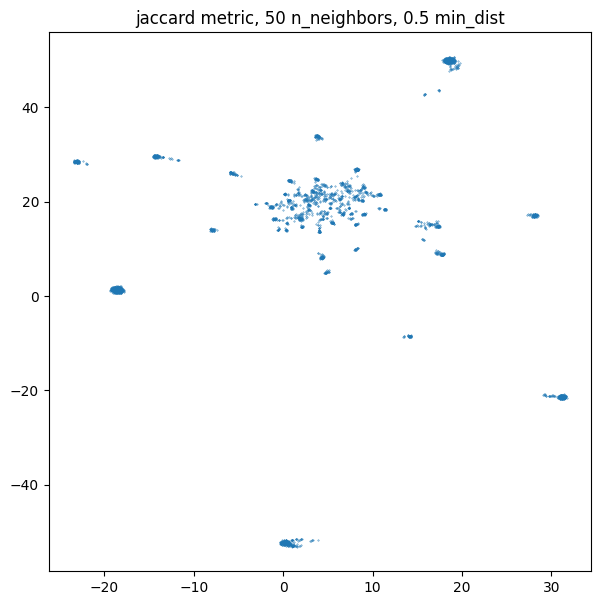

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


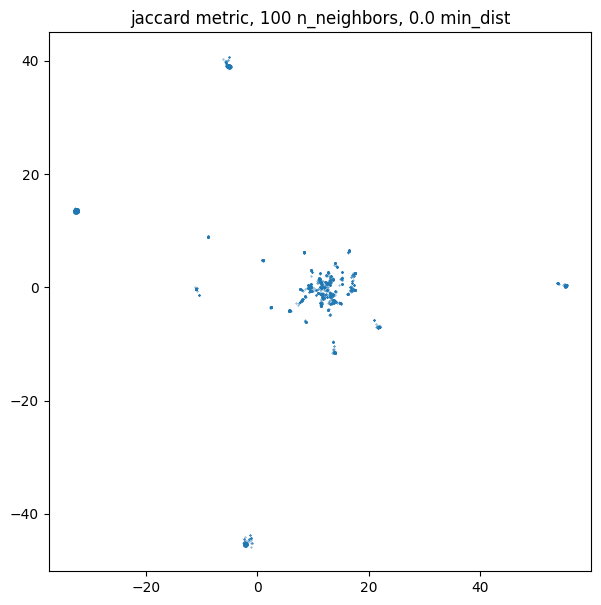

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


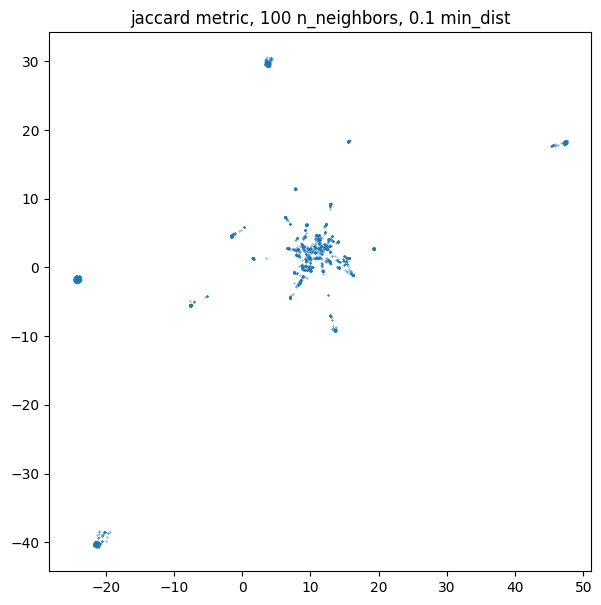

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


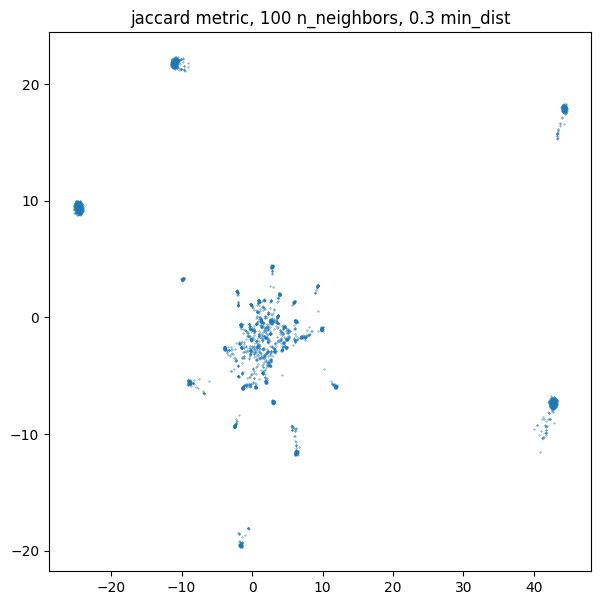

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


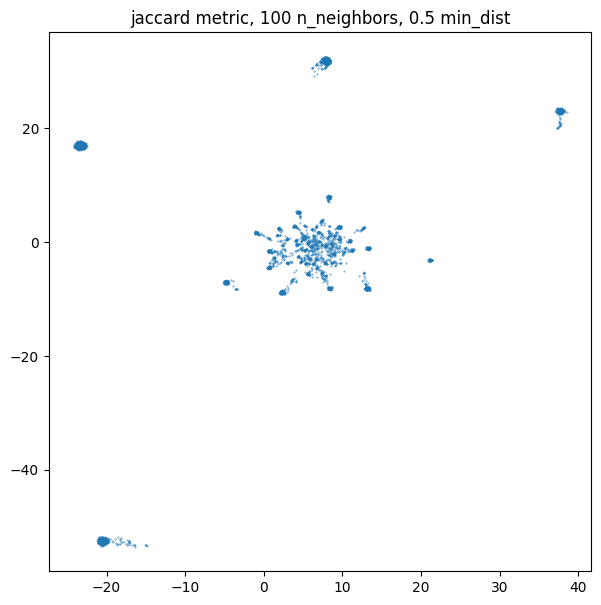

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


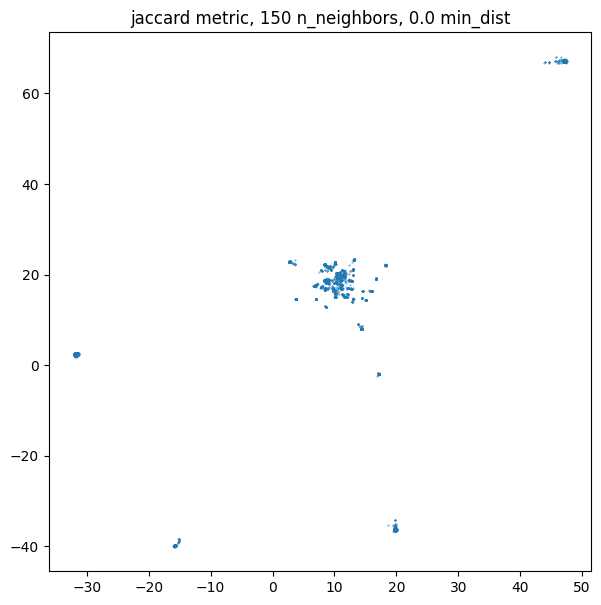

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


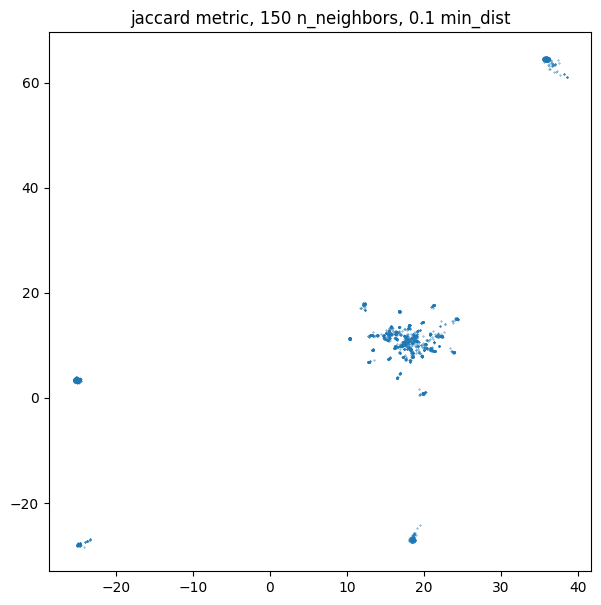

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


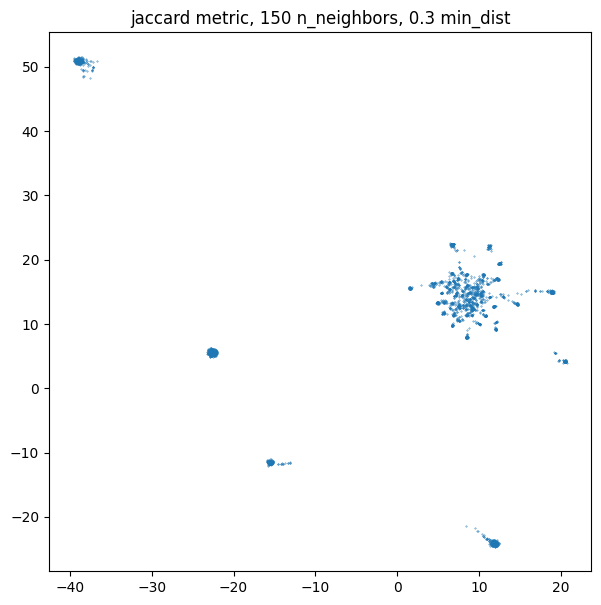

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


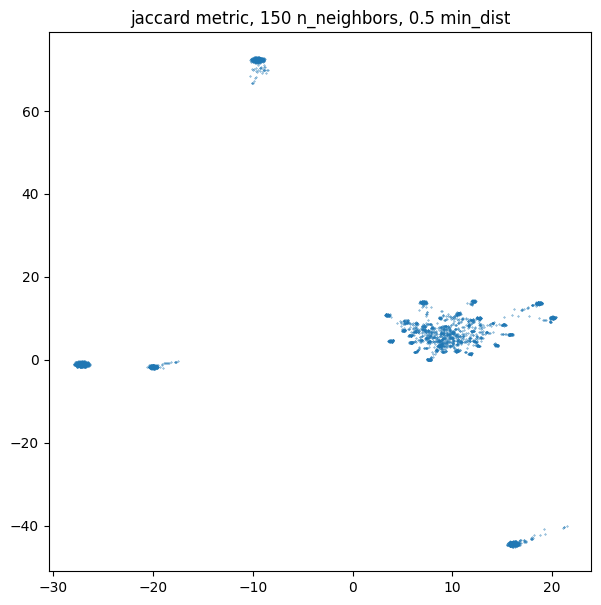

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


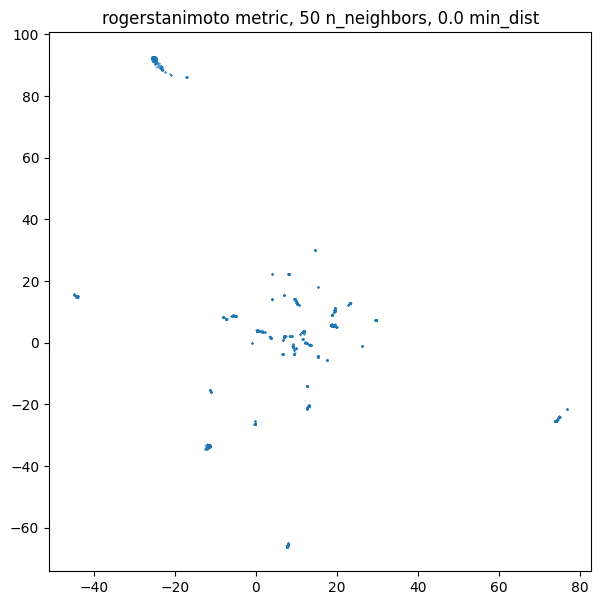

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


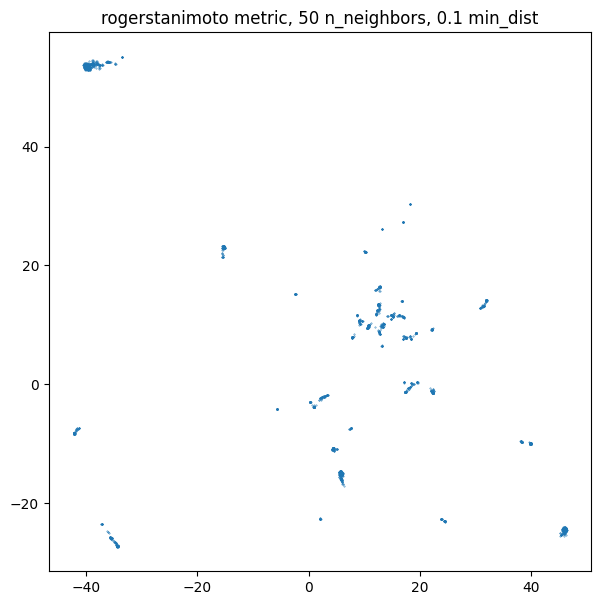

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


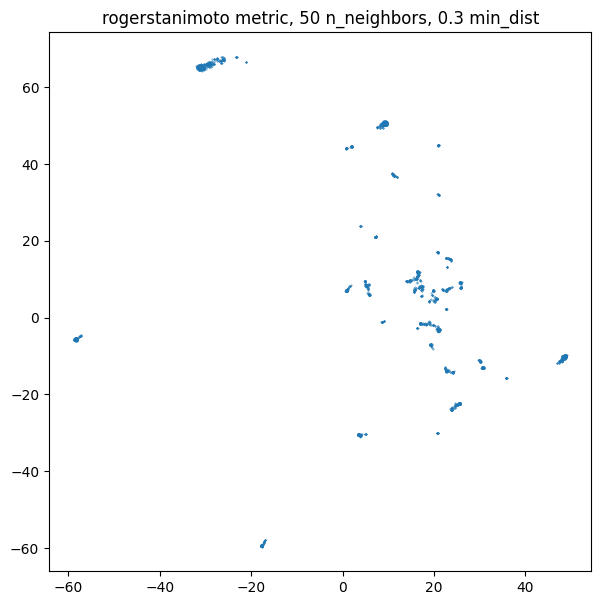

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


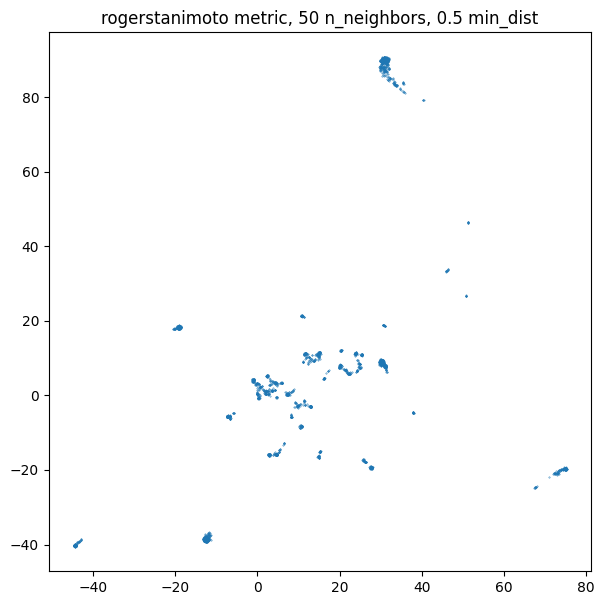

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


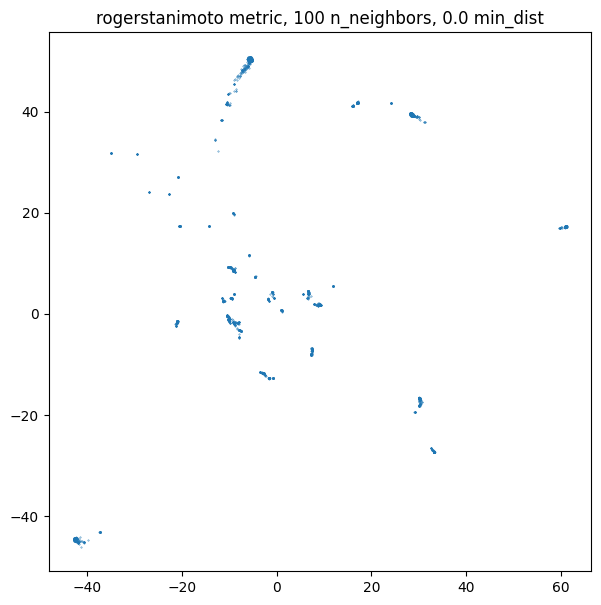

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


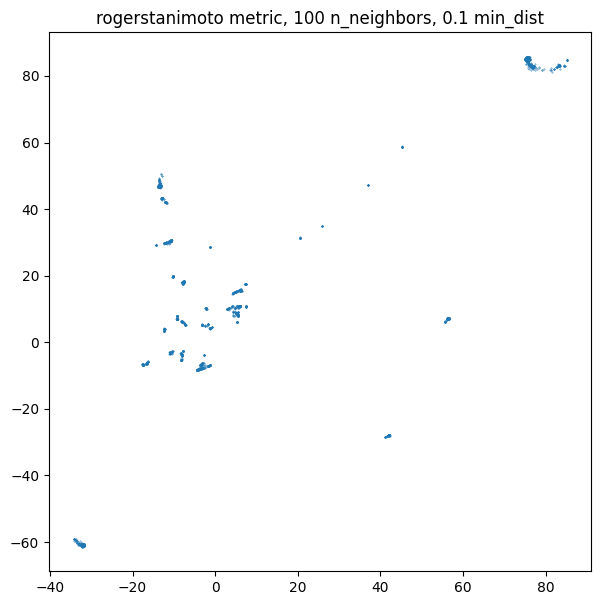

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


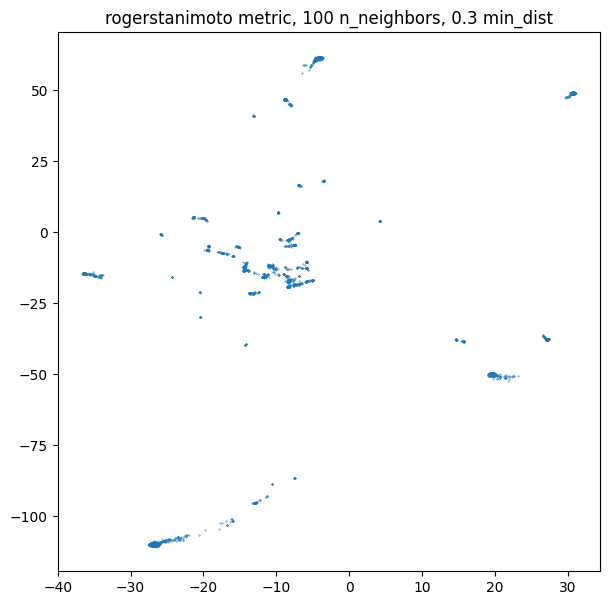

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


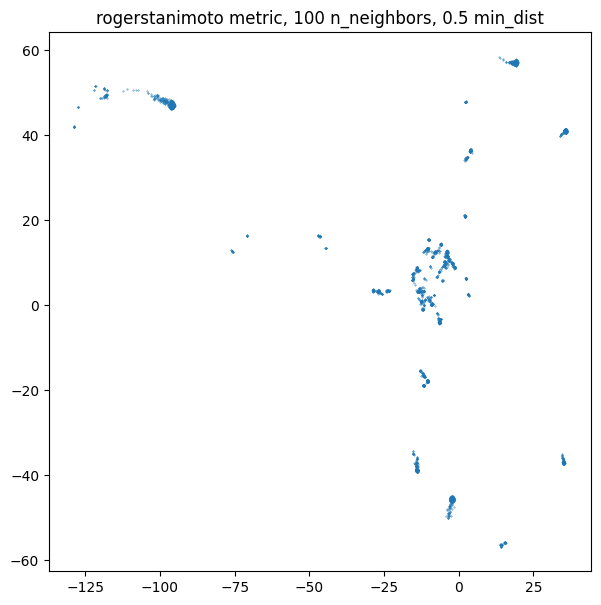

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


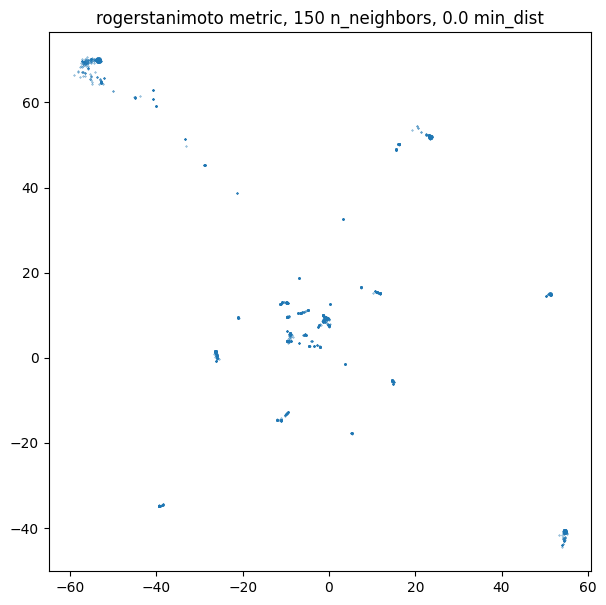

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


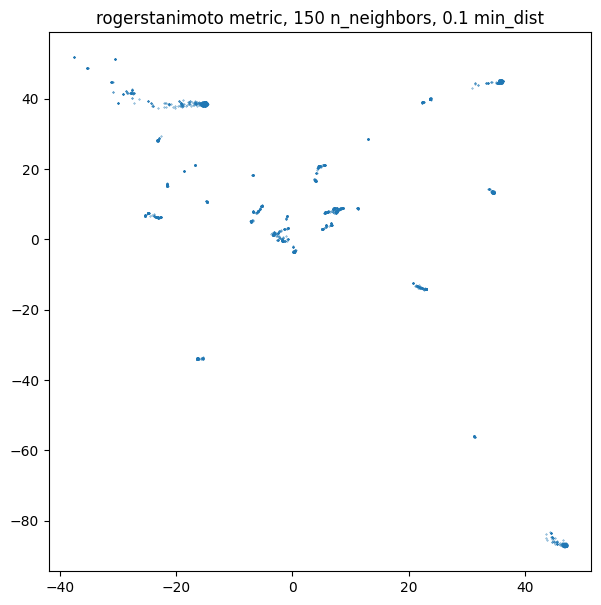

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


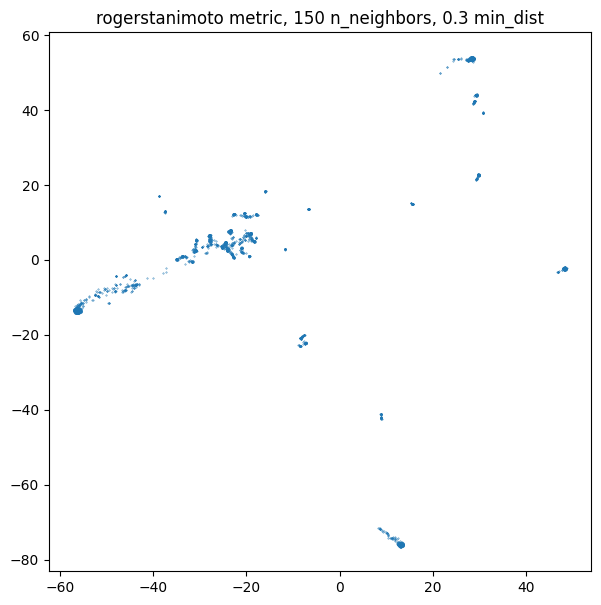

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


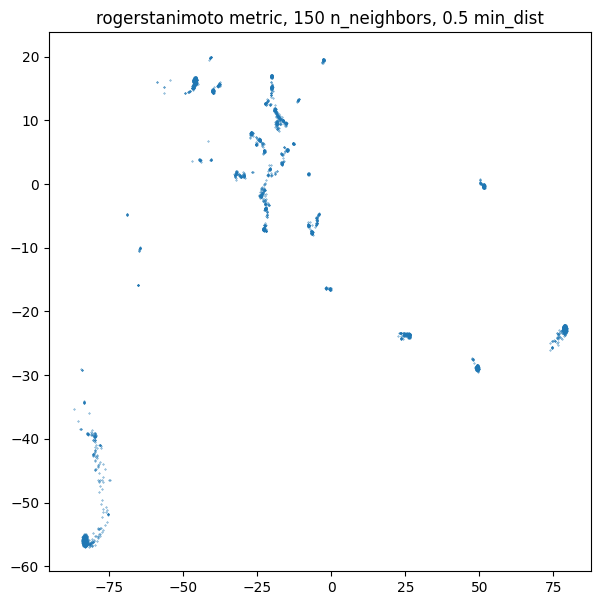

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


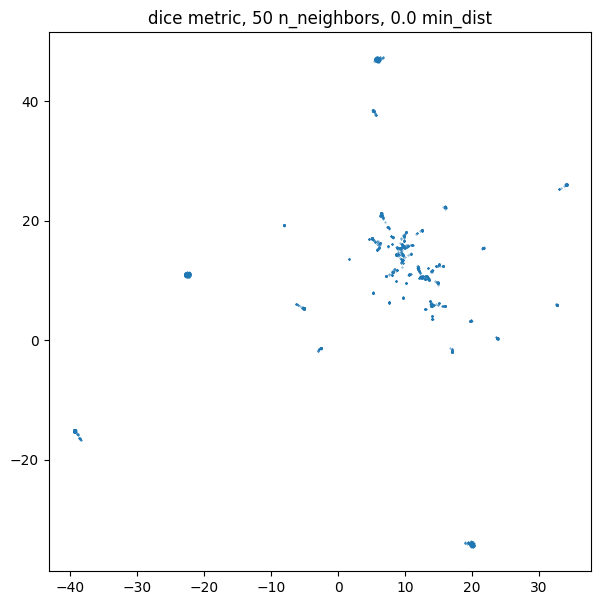

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


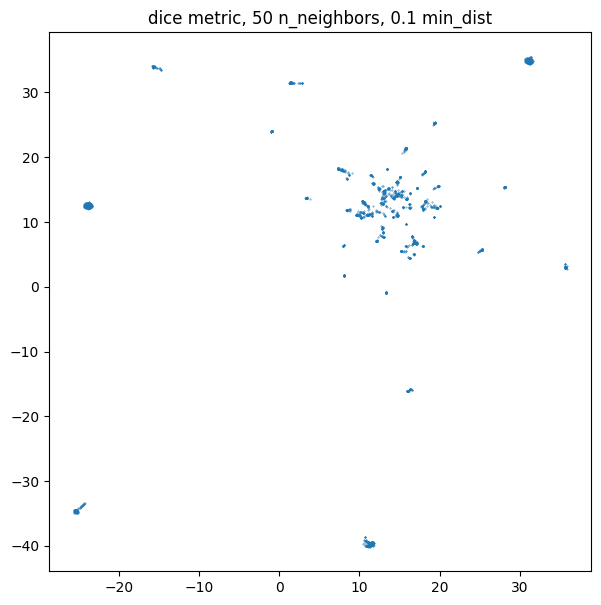

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


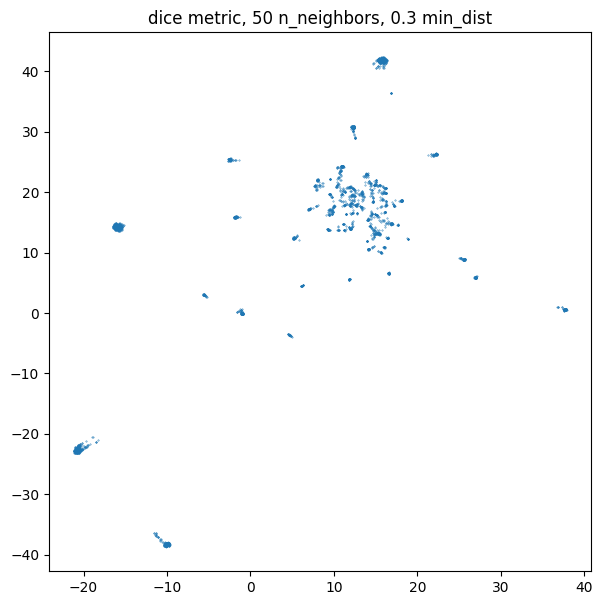

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


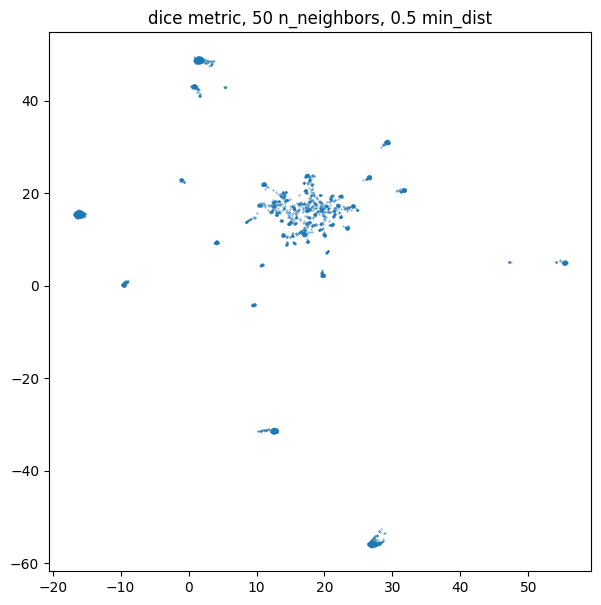

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


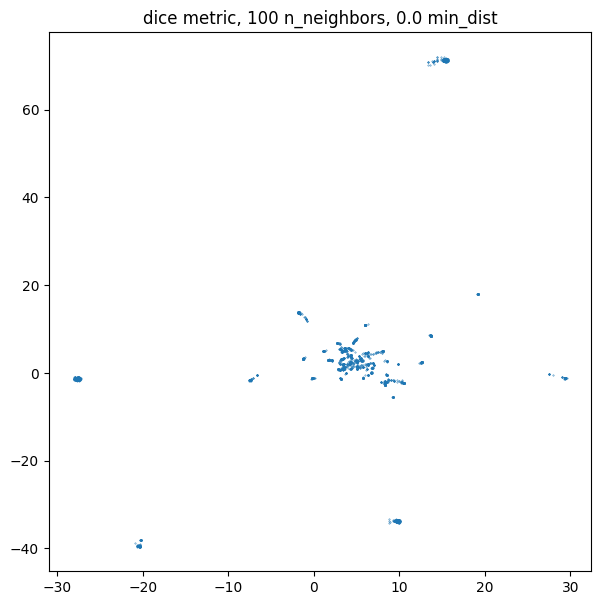

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


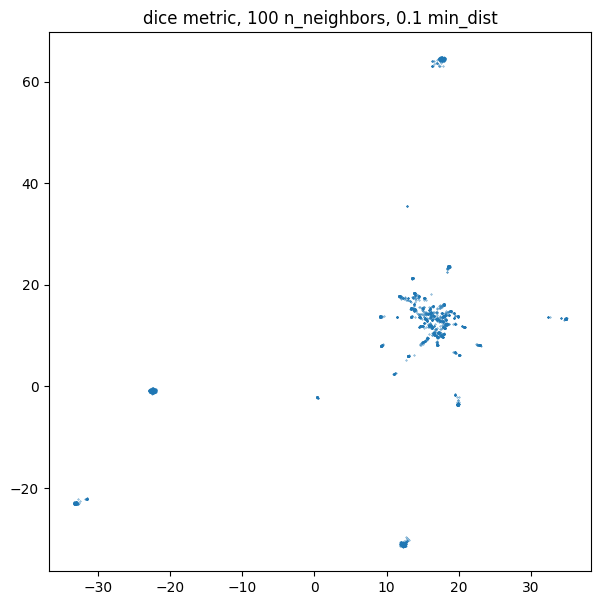

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


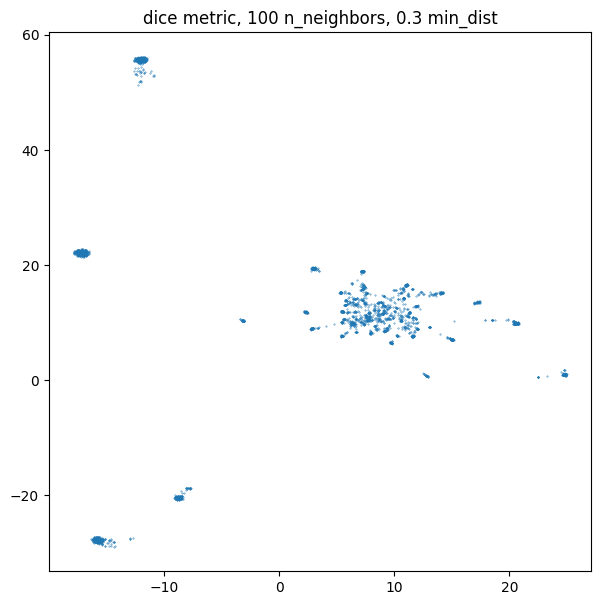

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


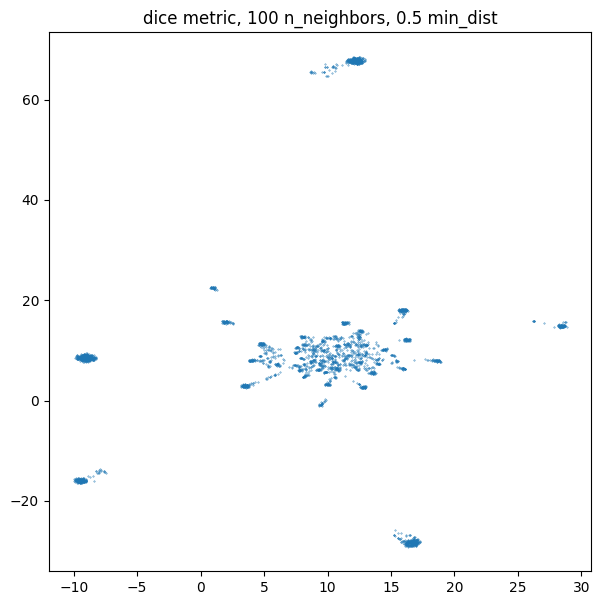

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


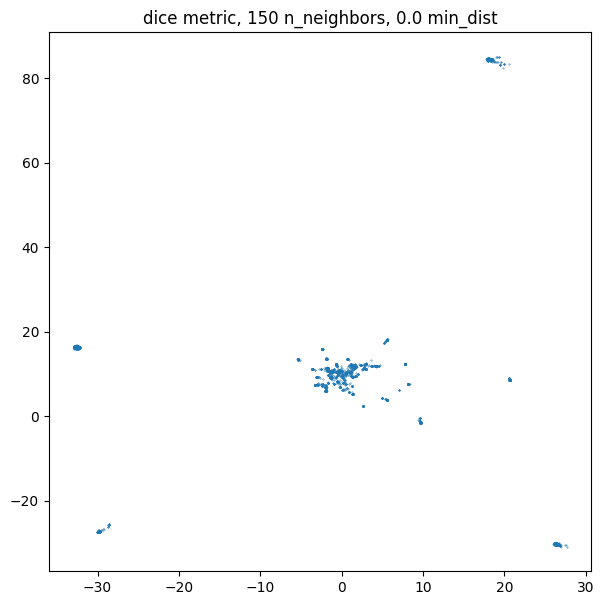

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


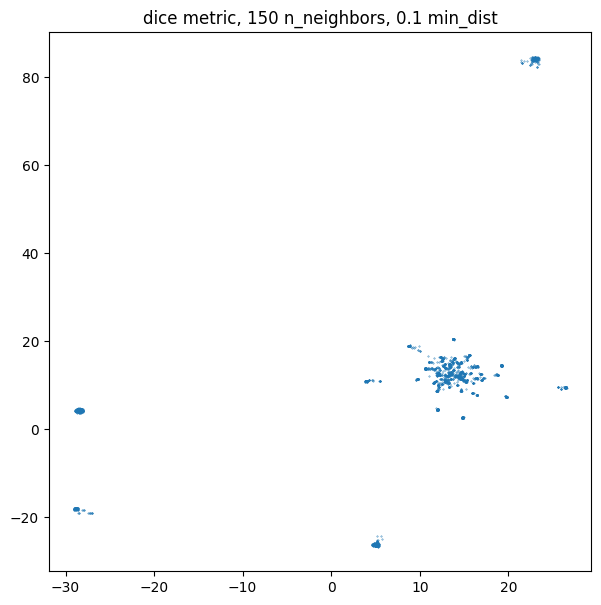

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


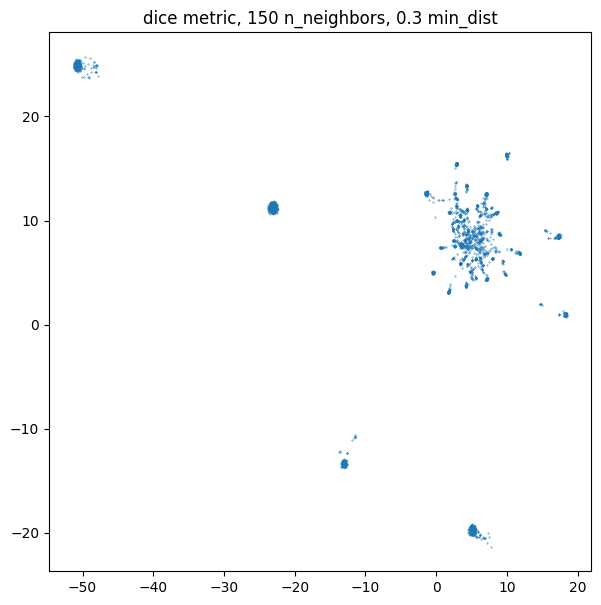

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\213004958.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


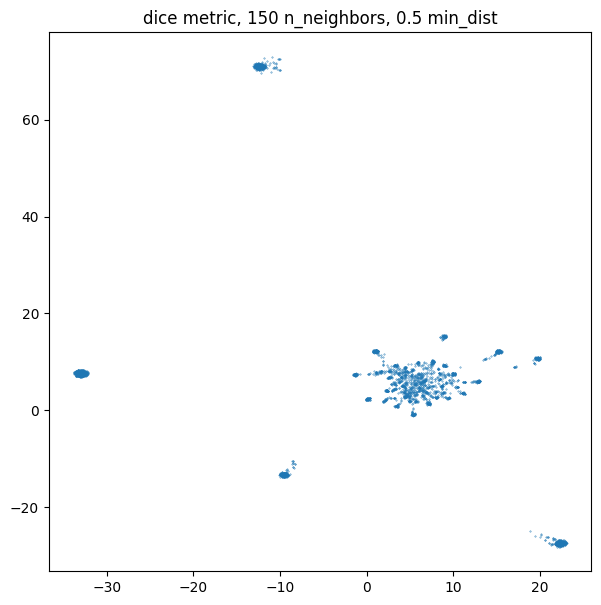

In [56]:
for dist, neigh, min_d in product(distances, neighbors, min_dist):
    clusterable_embedding = umap.UMAP(
        n_neighbors=neigh,
        min_dist=min_d, 
        n_components=2,
        random_state=42,
        metric=dist,
    ).fit_transform(X)
    
    fig, axs = plt.subplots(figsize=(7, 7))
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
    plt.title(f'{dist} metric, {neigh} n_neighbors, {min_d} min_dist')
    plt.show()

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


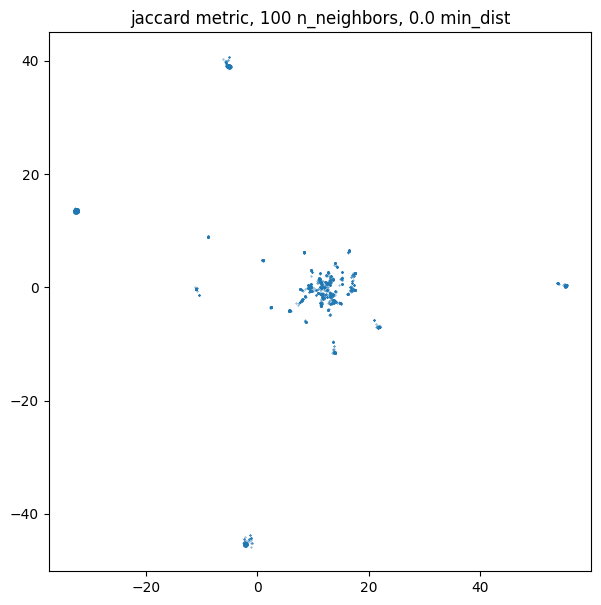

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


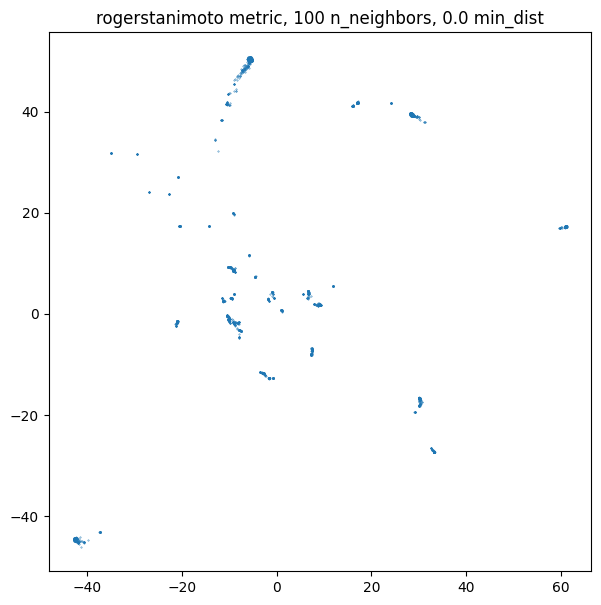

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


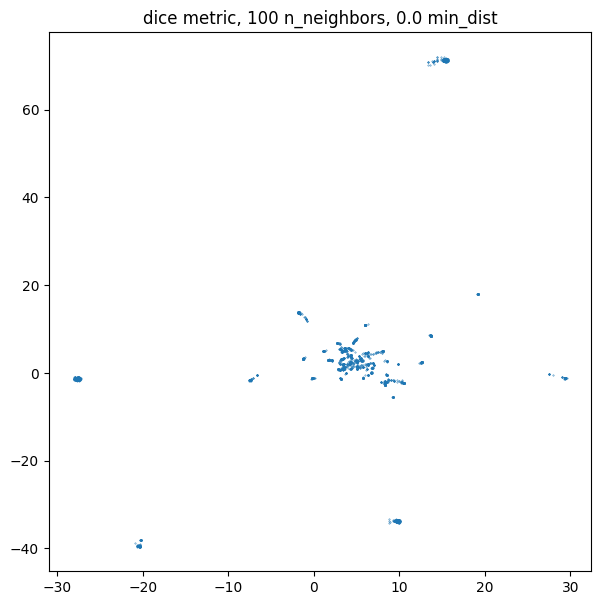

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


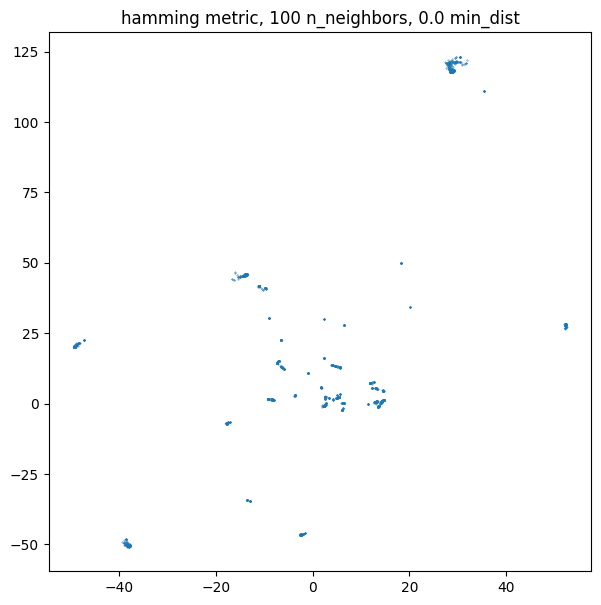

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


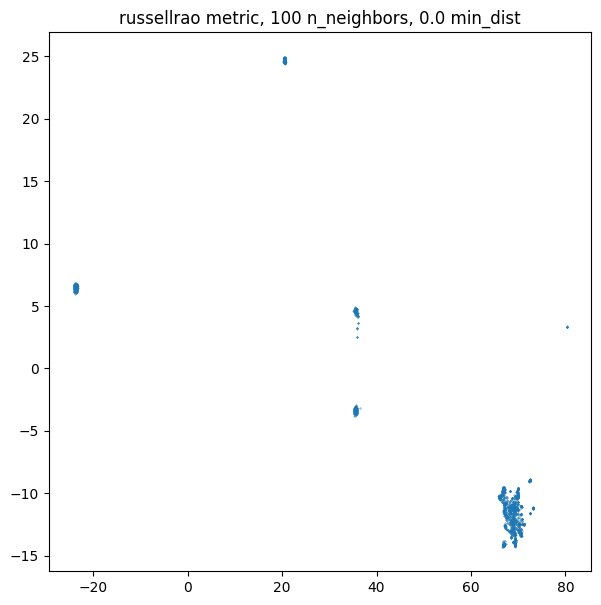

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for kulsinski distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


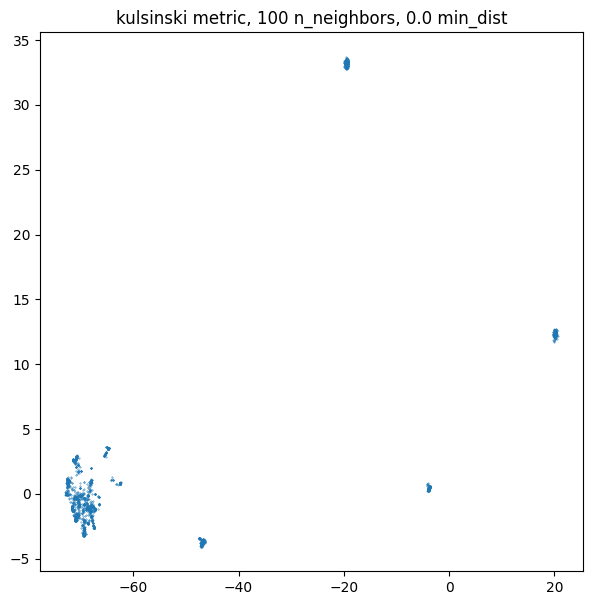

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalmichener distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


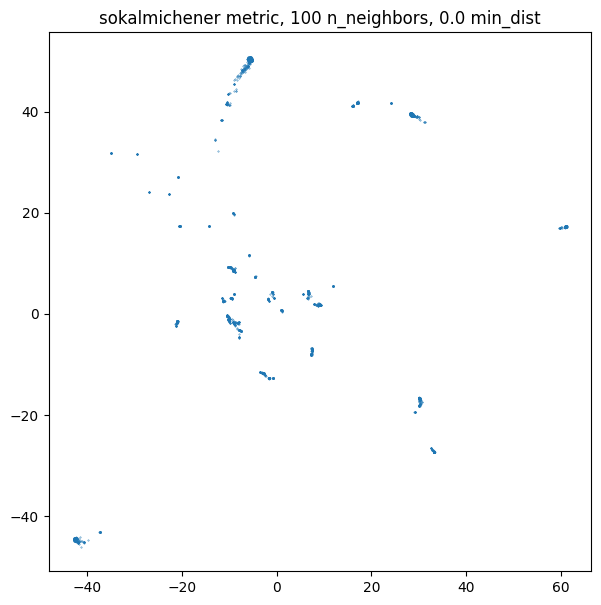

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for sokalsneath distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


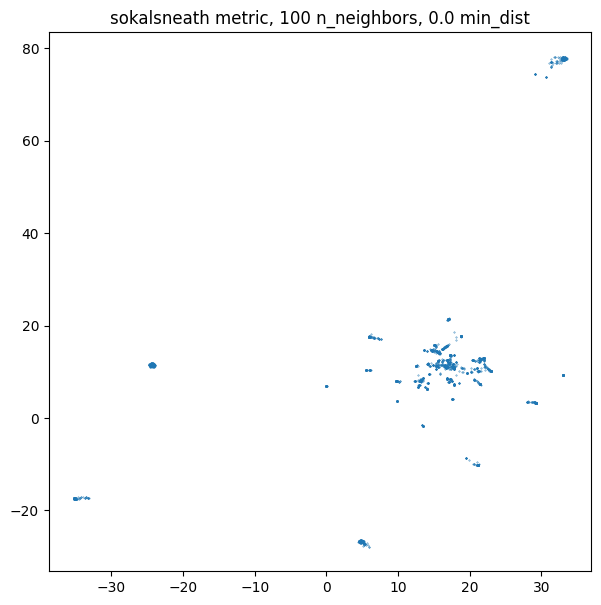

D:\Chem_conditions\venv\lib\site-packages\umap\umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(
C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\2320727207.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')


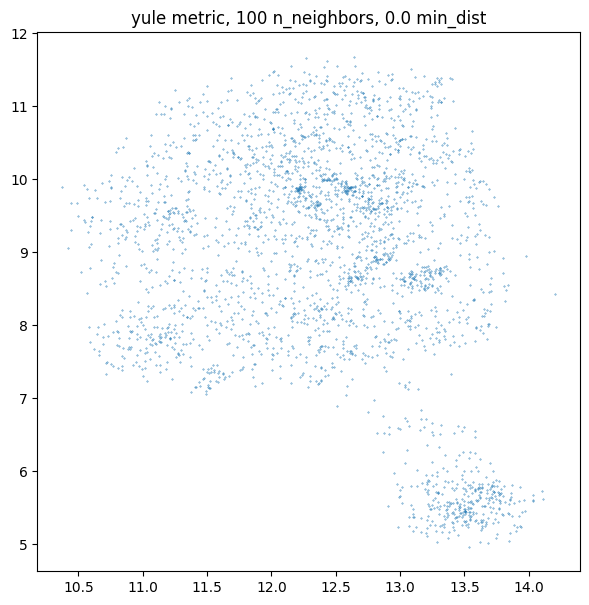

In [57]:
distances = ['jaccard', 'rogerstanimoto', 'dice', 'hamming', 'russellrao', 'kulsinski', 'sokalmichener', 'sokalsneath', 'yule']

neighbors = [100]
min_dist = [0.0]
for dist, neigh, min_d in product(distances, neighbors, min_dist):
    clusterable_embedding = umap.UMAP(
        n_neighbors=neigh,
        min_dist=min_d, 
        n_components=2,
        random_state=42,
        metric=dist,
    ).fit_transform(X)
    
    fig, axs = plt.subplots(figsize=(7, 7))
    plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral')
    plt.title(f'{dist} metric, {neigh} n_neighbors, {min_d} min_dist')
    plt.show()

C:\Users\nikit\AppData\Local\Temp\ipykernel_19924\3201458439.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, cmap='Spectral')


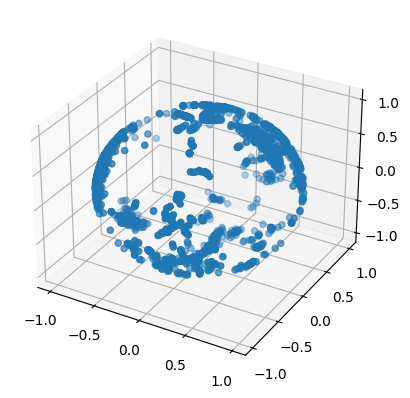

In [68]:
x = np.sin(clusterable_embedding[:, 0]) * np.cos(clusterable_embedding[:, 1])
y = np.sin(clusterable_embedding[:, 0]) * np.sin(clusterable_embedding[:, 1])
z = np.cos(clusterable_embedding[:, 0])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, cmap='Spectral')

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from drfp import DrfpEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

## Классификация на основе USPTO 

In [737]:
uspto = pd.read_csv('../data/raw/USPTO_50K.csv')
uspto

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...
...,...,...,...
50011,US20140194411A1,9,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...
50012,US20090149445A1,9,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...
50013,US08710243B2,9,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO>...
50014,US20130303532A1,9,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...


Сделаем аугументацию, поменяем реактанты местами

In [738]:
uspto['R1R2'], uspto['P'] = uspto['reactions'].str.split('>>', 1).str

C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\2193451479.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  uspto['R1R2'], uspto['P'] = uspto['reactions'].str.split('>>', 1).str
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\2193451479.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  uspto['R1R2'], uspto['P'] = uspto['reactions'].str.split('>>', 1).str


In [739]:
mask = uspto['R1R2'].str.split('.').apply(lambda x: len(x)) == 3
uspto = uspto[~mask]

In [742]:
uspto['P'].str.split('.').apply(lambda x: len(x)).max()

1

In [743]:
uspto['R1'], uspto['R2']= uspto['R1R2'].str.split('.', 1).str

C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\3494074689.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  uspto['R1'], uspto['R2']= uspto['R1R2'].str.split('.', 1).str
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\3494074689.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  uspto['R1'], uspto['R2']= uspto['R1R2'].str.split('.', 1).str
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\3494074689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uspto['R1'], uspto['R2']= uspto['R1R2'].str.split('.', 1).str
C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\3494074689.py:1: SettingWithCopyWarning: 
A va

In [746]:
reactions = uspto['R2'] + '.' + uspto['R1']
reactions[reactions.isna()] = uspto[reactions.isna()]['R1']
reactions = reactions + '>>' + uspto['P']

In [747]:
reactions

0        COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1        O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.N...
2        Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...
3        O=C(CF)CF.CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=...
4        O=C(Cl)OC1CCCC1.CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC...
                               ...                        
50011    CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...
50012    N#C[Cu].Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1>>N...
50013    NO.Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O>...
50014    O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...
50015    [N-]=[N+]=NCC1CCN(C(c2ccccc2)(c2ccccc2)c2ccccc...
Length: 49925, dtype: object

In [748]:
reactions = reactions.to_frame()
reactions['class'] = uspto['class']
reactions = reactions.rename(columns={0: 'reactions'})
reactions

,0,class
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,6
1,O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.N...,2
2,Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...,1
3,O=C(CF)CF.CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=...,1
4,O=C(Cl)OC1CCCC1.CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC...,2
...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,9
50012,N#C[Cu].Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1>>N...,9
50013,NO.Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O>...,9
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,9


In [774]:
full_uspto = pd.concat([uspto[['reactions', 'class']], reactions]).reset_index(drop=True)

In [775]:
full_uspto

,reactions,class
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,6
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,2
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,1
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,1
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,2
...,...,...
99845,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,9
99846,N#C[Cu].Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1>>N...,9
99847,NO.Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O>...,9
99848,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,9


In [776]:
full_uspto.to_csv('../data/interim/uspto_inverse.csv', index=False)

Объединим вещества в реакции

In [698]:
pd.read_csv('../data/interim/dataset_processed_clean_2.csv')

,reaction_id,reactants,reactants_II,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1
0,31-480-CAS-24139,119-53-9,NaN,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN
1,31-480-CAS-25495,119-53-9,NaN,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN
2,31-480-CAS-37840,119-53-9,NaN,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN
3,31-480-CAS-32067,119-53-9,NaN,134-81-6,1,8,Oxygen,NaN,NaN,NaN,NaN
4,31-480-CAS-32216,119-53-9,NaN,134-81-6,1,95,"Chromium, trichlorooxo(1,10-phenanthroline-N1,...",NaN,Dichloromethane,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
155536,31-177-CAS-4543302,900-99-2,100-42-5,661451-78-1,1,91,Sodium acetate,trans-Di(μ-acetato)bis[o-(di-o-tolylphosphino)...,Dimethylformamide,125.0,NaN
155537,31-614-CAS-30687581,9011-14-7,100-42-5,106911-77-7,1,43,NaN,879495-69-9,Tetrahydrofuran,25.0,NaN
155538,31-614-CAS-26051353,9011-14-7,100-42-5,696598-57-9,1,85,NaN,NaN,Chloroform,100.0,NaN
155539,31-614-CAS-26567521,9011-14-7,100-42-5,696598-57-9,1,85,NaN,Azobisisobutyronitrile,Toluene,70.0,NaN


In [767]:
df_full = pd.read_csv('../data/interim/dataset_smiles_descriptors.tsv',sep="\t")

C:\Users\nikit\AppData\Local\Temp\ipykernel_20972\1028813262.py:1: DtypeWarning: Columns (5,6,10,11,12,24,31,34,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('../data/interim/dataset_smiles_descriptors.tsv',sep="\t")


In [768]:
df_full.columns

Index(['reaction_id', 'reactants', 'products', 'stages_number', 'yield_value',
       'reagents_1', 'catalysts_1', 'solvents_1', 'temperature_1',
       'pressure_1', 'reagents_1_II', 'solvents_1_II', 'catalysts_1_II',
       'reactants_II', 'reactants_smiles', 'reactants_II_smiles',
       'products_smiles', 'solvents_1_smiles',
       'solvents_1_surface_tension_N/m', 'solvents_1_molar_refractivity',
       'solvents_1_num_H_acceptors', 'solvents_1_num_H_donors',
       'solvents_1_aromaticity', 'solvents_1_halogenicity',
       'solvents_1_II_smiles', 'solvents_1_II_surface_tension_N/m',
       'solvents_1_II_molar_refractivity', 'solvents_1_II_num_H_acceptors',
       'solvents_1_II_num_H_donors', 'solvents_1_II_aromaticity',
       'solvents_1_II_halogenicity', 'catalysts_1_smiles',
       'catalysts_1_LabuteASA', 'catalysts_1_NumberMetalAtoms',
       'catalysts_1_II_smiles', 'catalysts_1_II_LabuteASA',
       'catalysts_1_II_NumberMetalAtoms', 'reagents_1_smiles',
       'reagen

In [769]:
df_full['reaction_smiles'] = 0
mask = df_full['reactants_II_smiles'].isna()

In [770]:
df_full.loc[~mask, 'reaction_smiles'] = df_full['reactants_smiles'] + '.' + df_full['reactants_II_smiles'] + '>>' + df_full['products_smiles'] 
df_full.loc[mask, 'reaction_smiles'] = df_full['reactants_smiles'] + '>>' + df_full['products_smiles']

In [771]:
df_full['reaction_smiles']

0         N(c1ccccc1)c2ccccc2.[O-][N+](=O)c1ccc(Cl)cc1>>...
1         Cc1ccc(Br)cc1.COc1ccc(cc1)C(O)=O>>CC1=CC=C(C=C...
2         Cl.O=C(OC)CC(N)CC=1C=CC=CC1.O=Cc1ccccc1>>O=C(O...
3         [H+].[Cl-].CNO.CN(C)c1ccc(C=O)cc1>>CN(C)c1ccc(...
4         ON=C(C=CC=1C=CC=CC1)C=CC=2C=CC=CC2.OB(O)C1=CCO...
                                ...                        
108932    [O-][N+](=O)c1cccc(C=O)c1>>OCc1cccc(c1)[N+]([O...
108933                       CN(N=O)c1ccccc1>>CN(N)c1ccccc1
108934    OC(c1occc1)C(=O)c2occc2>>O=C(C(=O)c1occc1)c2occc2
108935                         CCOC(OCC)\C=C\CC>>CC/C=C/C=O
108936    S=C(OC1=CC=C(C=C1)C=2C=NC3=C(C=CC=4C=C(C=NC43)...
Name: reaction_smiles, Length: 108937, dtype: object

In [849]:
df_full.to_csv('../data/interim/dataset_smiles_descriptors+reaction_smiles.tsv', index=False, sep="\t")

Переведем реакции в фингерпринты

In [5]:
# full_uspto['reaction_drfp'] = DrfpEncoder.encode(full_uspto['reactions'].to_list(), n_folded_length=512)

In [42]:
full_uspto = pd.read_csv('../data/interim/uspto_inverse_drfp.csv')

In [43]:
def to_array_str(x):
    return np.fromstring(x[8:-16].replace('\n      ', ''), sep=',')


full_uspto.reaction_drfp = full_uspto.reaction_drfp.apply(to_array_str)

In [44]:
full_uspto

,reactions,class,reaction_drfp
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,6,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,2,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
99845,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99846,N#C[Cu].Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1>>N...,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99847,NO.Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O>...,9,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99848,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


<AxesSubplot: >

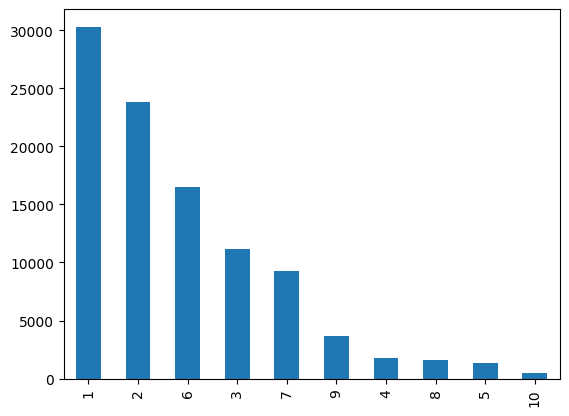

In [826]:
full_uspto['class'].value_counts().plot(kind='bar')

In [45]:
uspto_fp = pd.DataFrame(full_uspto.reaction_drfp.values.tolist())

In [46]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(uspto_fp, full_uspto['class'], test_size=0.25, 
                                                    random_state=42, shuffle=True)

<AxesSubplot: >

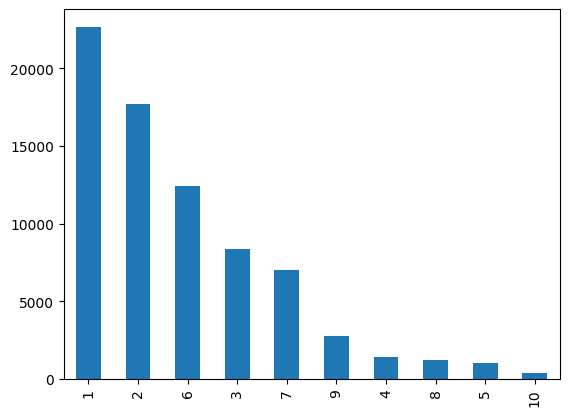

In [81]:
y_train.value_counts().plot(kind='bar')

<AxesSubplot: >

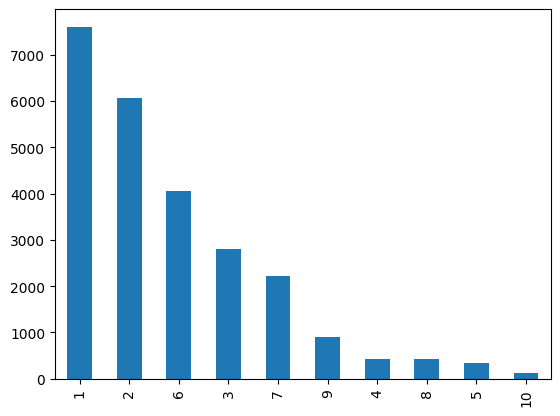

In [19]:
y_test.value_counts().plot(kind='bar')

#### Метод ближайших соседей

In [82]:
classifier = KNeighborsClassifier(n_neighbors = 2, metric='jaccard')
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='jaccard', n_neighbors=2)

In [83]:
y_pred = classifier.predict(X_test)

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

In [858]:
accuracy_score(y_pred, y_test)

0.9679926290910548

In [50]:
print(confusion_matrix(y_test, y_pred))

[[7538   24    6    0    4   22    2    2   10    0]
 [  19 5996    0    0    6   36    8    0    2    0]
 [  37   16 2741    2    0    0    4    2    4    0]
 [   6    6    1  415    0    0    0    2    0    0]
 [   1    2    0    0  327    2    2    0    0    0]
 [  51   37    1    0   21 3938    2    0    0    0]
 [  25   39   26    9    3   54 2054   13    6    0]
 [   3    2    3    0    0    3  110  303    0    0]
 [  61   32   23    0    2   15   20    3  744    0]
 [   3    1    0    0    0    0    3    0    0  108]]


<AxesSubplot: >

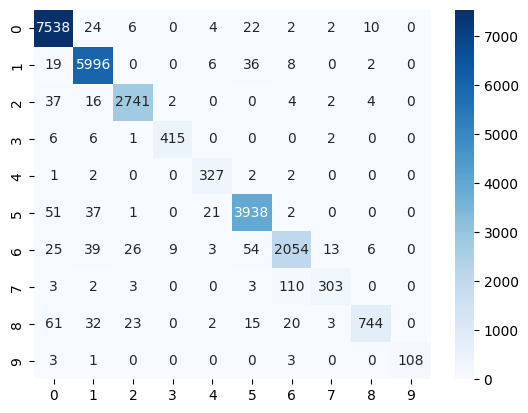

In [57]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', cmap='Blues')
ax.xaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])
ax.yaxis.set_ticklabels(['Setosa','Versicolor', 'Virginia'])

In [85]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.drop('support', axis=1)

,precision,recall,f1-score
1,0.973399,0.990799,0.982022
2,0.974167,0.988297,0.981181
3,0.978579,0.976835,0.977706
4,0.974178,0.965116,0.969626
5,0.900826,0.979042,0.938307
6,0.967568,0.972346,0.969951
7,0.931519,0.921489,0.926477
8,0.932308,0.714623,0.809079
9,0.971279,0.826667,0.893157
10,1.000000,0.939130,0.968610


In [84]:
report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
report_df = pd.DataFrame(report).T.sort_values(by=['precision', 
                                                   'recall', 'f1-score'], ascending=False).drop(['support'], axis=1)
report_df

,precision,recall,f1-score
class 9,1.000000,0.939130,0.968610
class 2,0.978579,0.976835,0.977706
class 3,0.974178,0.965116,0.969626
class 1,0.974167,0.988297,0.981181
class 0,0.973399,0.990799,0.982022
class 8,0.971279,0.826667,0.893157
accuracy,0.967993,0.967993,0.967993
weighted avg,0.967873,0.967993,0.967413
class 5,0.967568,0.972346,0.969951
macro avg,0.960382,0.927434,0.941612


In [859]:
report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
report_df = pd.DataFrame(report).T.sort_values(by=['precision', 
                                                   'recall', 'f1-score'], ascending=False).drop(['support'], axis=1)
report_df

,precision,recall,f1-score
class 9,1.000000,0.939130,0.968610
class 2,0.978579,0.976835,0.977706
class 3,0.974178,0.965116,0.969626
class 1,0.974167,0.988297,0.981181
class 0,0.973399,0.990799,0.982022
class 8,0.971279,0.826667,0.893157
accuracy,0.967993,0.967993,0.967993
weighted avg,0.967873,0.967993,0.967413
class 5,0.967568,0.972346,0.969951
macro avg,0.960382,0.927434,0.941612


In [12]:
df_full = pd.read_csv('../data/interim/dataset_smiles_descriptors+reaction_fp.tsv',sep="\t")

C:\Users\nikit\AppData\Local\Temp\ipykernel_8244\4093589537.py:1: DtypeWarning: Columns (5,6,10,11,12,24,31,34,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv('../data/interim/dataset_smiles_descriptors+reaction_fp.tsv',sep="\t")


In [13]:
def to_array_str(x):
    return np.fromstring(x[1:-1].replace('\n', ''), sep=' ')


df_full.reaction_drfp = df_full.reaction_drfp.apply(to_array_str)

In [14]:
df_fp = pd.DataFrame(df_full.reaction_drfp.values.tolist())

In [868]:
df_full['class'] = classifier.predict(df_fp)

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

In [869]:
df_full[['reaction_smiles', 'class']]

,reaction_smiles,class
0,N(c1ccccc1)c2ccccc2.[O-][N+](=O)c1ccc(Cl)cc1>>...,9
1,Cc1ccc(Br)cc1.COc1ccc(cc1)C(O)=O>>CC1=CC=C(C=C...,1
2,Cl.O=C(OC)CC(N)CC=1C=CC=CC1.O=Cc1ccccc1>>O=C(O...,1
3,[H+].[Cl-].CNO.CN(C)c1ccc(C=O)cc1>>CN(C)c1ccc(...,1
4,ON=C(C=CC=1C=CC=CC1)C=CC=2C=CC=CC2.OB(O)C1=CCO...,3
...,...,...
108932,[O-][N+](=O)c1cccc(C=O)c1>>OCc1cccc(c1)[N+]([O...,7
108933,CN(N=O)c1ccccc1>>CN(N)c1ccccc1,7
108934,OC(c1occc1)C(=O)c2occc2>>O=C(C(=O)c1occc1)c2occc2,6
108935,CCOC(OCC)\C=C\CC>>CC/C=C/C=O,6


In [872]:
df_full.to_csv('../data/interim/dataset_smiles_descriptors_classified.tsv', index=False, sep="\t")

In [871]:
df_full[['reaction_id', 'reaction_smiles', 'class']].to_csv('../data/interim/dataset_smiles_classified.tsv', index=False, sep="\t")

,reaction_id,reactants,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,...,catalysts_1_II_NumberMetalAtoms,reagents_1_smiles,reagents_1_org/inorg,reagents_1_upclass,reagents_1_II_smiles,reagents_1_II_org/inorg,reagents_1_II_upclass,reaction_smiles,reaction_drfp,class
0,31-172-CAS-18978708,122-39-4,4316-57-8,1,71,Sodium tert-butoxide,Palladium diacetate,NaN,NaN,NaN,...,0.0,[Na+].CC(C)(C)[O-],o,Organic salt,[Na+].[Na+].[O-][S]([O-])(=O)=O,i,Inorganic salt,N(c1ccccc1)c2ccccc2.[O-][N+](=O)c1ccc(Cl)cc1>>...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9
1,31-144-CAS-20809214,106-38-7,1216-95-1,1,91,Cesium carbonate,Palladium diacetate,Dimethylformamide,25.0,NaN,...,NaN,[Cs+].[Cs+].[O-]C([O-])=O,i,Inorganic salt,[Na+].[Na+].[O-][S]([O-])(=O)=O,i,Inorganic salt,Cc1ccc(Br)cc1.COc1ccc(cc1)C(O)=O>>CC1=CC=C(C=C...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,31-309-CAS-11061124,1001427-55-9,1001427-60-6,1,83,Triethylamine,NaN,Dichloromethane,25.0,NaN,...,NaN,CCN(CC)CC,o,Amine,[Na+].[Na+].[O-][S]([O-])(=O)=O,i,Inorganic salt,Cl.O=C(OC)CC(N)CC=1C=CC=CC1.O=Cc1ccccc1>>O=C(O...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,31-311-CAS-14967007,4229-44-1,16089-69-3,1,95,Sodium carbonate,NaN,NaN,25.0,NaN,...,NaN,[Na+].[Na+].[O-]C([O-])=O,i,Inorganic salt,[Na+].[Na+].[O-][S]([O-])(=O)=O,i,Inorganic salt,[H+].[Cl-].CNO.CN(C)c1ccc(C=O)cc1>>CN(C)c1ccc(...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4,31-614-CAS-26958594,1028801-18-4,2227266-52-4,1,50,Pyridine,Cupric acetate,"1,2-Dichloroethane",25.0,NaN,...,NaN,c1ccncc1,o,Heterocyclic cmpd.,[Na+].[Na+].[O-][S]([O-])(=O)=O,i,Inorganic salt,ON=C(C=CC=1C=CC=CC1)C=CC=2C=CC=CC2.OB(O)C1=CCO...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",3


In [25]:
scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

In [21]:
knn2 = KNeighborsClassifier(metric='jaccard')
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = RandomizedSearchCV(knn2, param_grid, cv=5, scoring='f1_weighted')
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_, knn_gscv.best_score_

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

({'n_neighbors': 2}, 0.9620171904240976)

In [27]:
classifier = KNeighborsClassifier(n_neighbors = knn_gscv.best_params_['n_neighbors'], metric='jaccard')
scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_weighted')

D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
D:\Chem_conditions\venv\lib\site-package

In [28]:
scores

array([0.96064309, 0.96065017, 0.96245739, 0.96439538, 0.96193993])

#### Ансамбль

In [58]:
y_train = y_train -1
y_test = y_test -1

In [59]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

In [26]:
params = {
 'learning_rate': [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth': [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight': [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [41]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)

In [42]:
clf = RandomizedSearchCV(xgb_clf, param_distributions = params, n_iter = 25, scoring = 'f1_weighted', cv=3)

In [44]:
clf.fit(X_train, y_train, verbose=1)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=['merror', 'mlogloss'],
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=N...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_class=10, num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=25,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1_weighted')

In [45]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softmax', ...)

In [46]:
clf.best_params_

{'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

In [60]:
best_params = {'min_child_weight': 1,
 'max_depth': 15,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

In [61]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42, 
                           **best_params)

In [62]:
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softmax', ...)

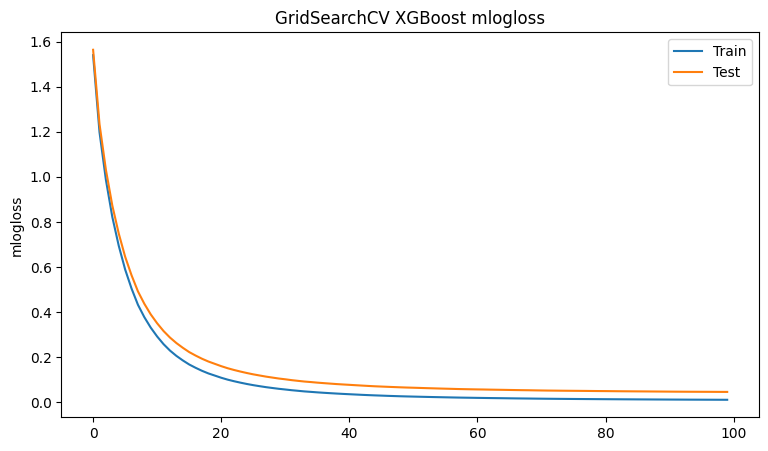

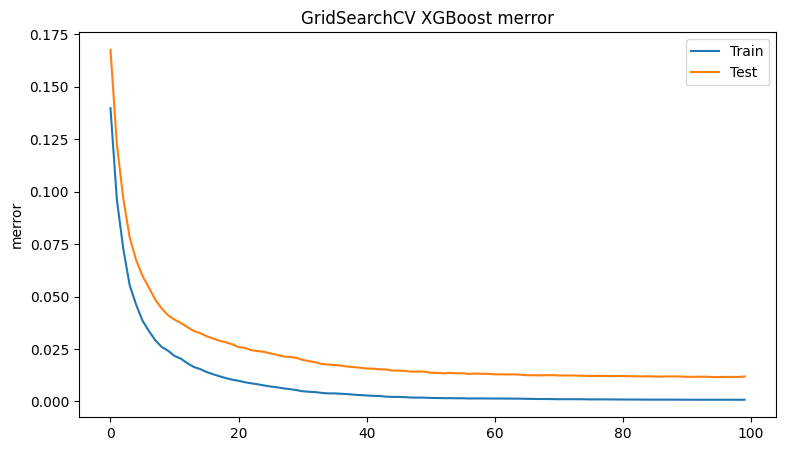


------------------ Confusion Matrix -----------------

[[7578   19    2    2    0    0    5    0    2    0]
 [   6 6042    0    0    0   16    1    0    2    0]
 [  34    6 2756    2    0    0    8    0    0    0]
 [  10    4    0  416    0    0    0    0    0    0]
 [   0    0    0    0  334    0    0    0    0    0]
 [   4    5    2    0    0 4033    6    0    0    0]
 [  12    6    4    0    0   13 2149   37    8    0]
 [   2    0    2    0    0    2   23  395    0    0]
 [  28    2    2    0    0    6   10    0  852    0]
 [   0    0    2    0    0    0    2    0    0  111]]

Accuracy: 0.99
Balanced Accuracy: 0.97

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.97
Macro F1-score: 0.98

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7608
          

In [68]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------')

<AxesSubplot: >

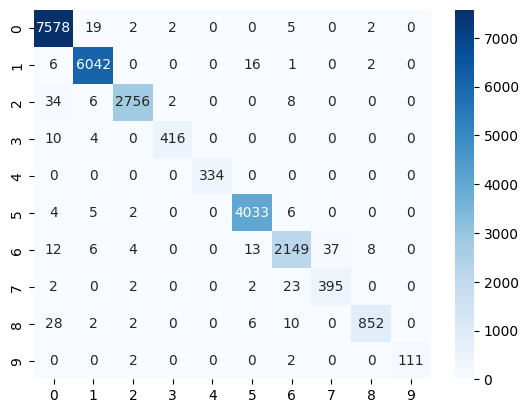

In [69]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', cmap='Blues')

In [70]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.drop('support', axis=1)

,precision,recall,f1-score
0,0.987490,0.996057,0.991755
1,0.993097,0.995879,0.994486
2,0.994946,0.982181,0.988522
3,0.990476,0.967442,0.978824
4,1.000000,1.000000,1.000000
5,0.990909,0.995802,0.993350
6,0.975045,0.964109,0.969547
7,0.914352,0.931604,0.922897
8,0.986111,0.946667,0.965986
9,1.000000,0.965217,0.982301


Объединим два класса

In [71]:
# заменяем 8й класс на 7й 
y_train = y_train.replace(7, 6)
y_test = y_test.replace(7, 6)

In [72]:
y_train = y_train.replace([8, 9], [7, 8])
y_test = y_test.replace([8, 9], [7, 8])

In [73]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=9, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
clf = RandomizedSearchCV(xgb_clf, param_distributions = params, n_iter = 25, scoring = 'f1_weighted', cv=3)

In [67]:
clf.fit(X_train, y_train, verbose=1)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=['merror', 'mlogloss'],
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_class=9, num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=25,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='f1_weighted')

In [68]:
clf.best_params_

{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [74]:
best_params = {'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [75]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42, 
                           **best_params)

In [76]:
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=10, num_parallel_tree=None, objective='multi:softmax', ...)

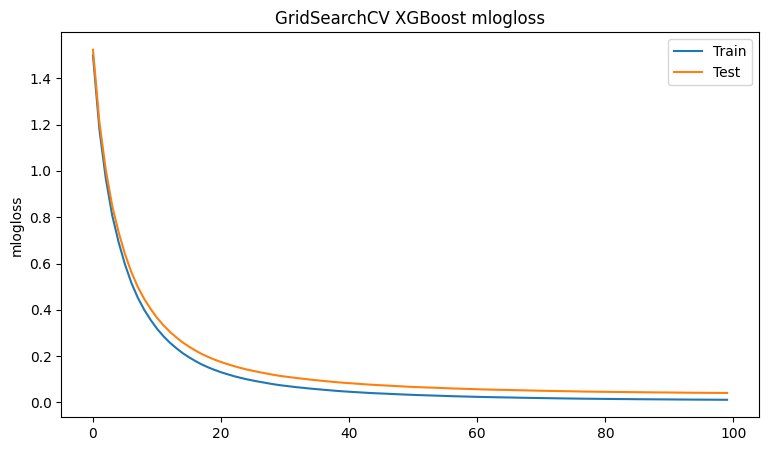

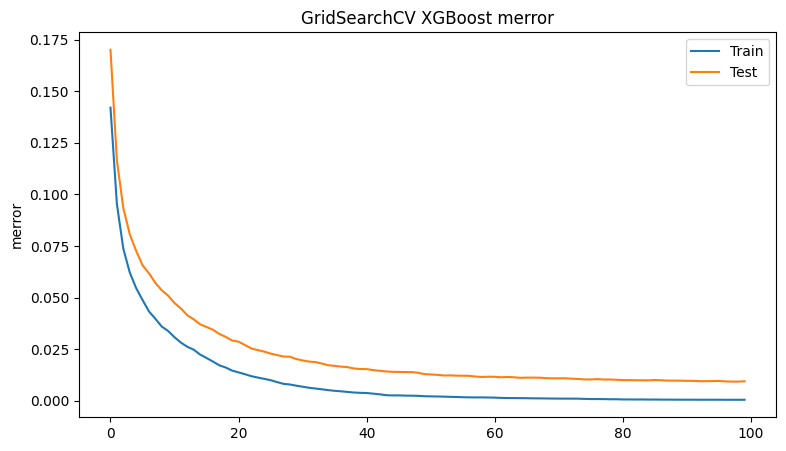


------------------ Confusion Matrix -----------------

[[7577   14    4    0    0    5    4    4    0]
 [   4 6039    0    0    0   20    0    4    0]
 [  34    2 2754    2    0    0   12    2    0]
 [  10    4    0  416    0    0    0    0    0]
 [   0    0    0    0  334    0    0    0    0]
 [   6    6    2    0    0 4030    6    0    0]
 [  18    9    0    0    0   19 2599    8    0]
 [  16    2    2    0    0    4   10  866    0]
 [   0    0    2    0    0    0    2    0  111]]

Accuracy: 0.99
Balanced Accuracy: 0.98

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.98
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7608
           1       0.99      1.00      0.99      6067
           2       1.00      0.98      0.99      2806


In [77]:
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('GridSearchCV XGBoost merror')
plt.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = xgb_clf.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------')

<AxesSubplot: >

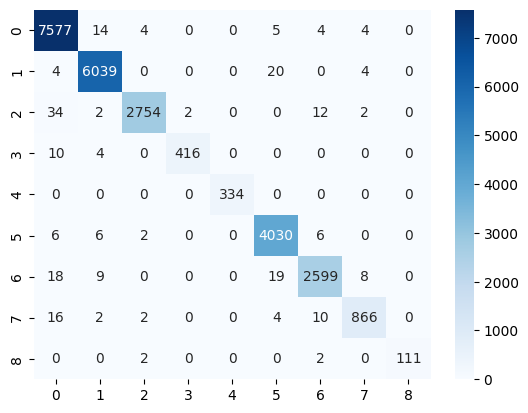

In [78]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', cmap='Blues')

In [79]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.drop('support', axis=1)

,precision,recall,f1-score
0,0.988519,0.995925,0.992208
1,0.993910,0.995385,0.994647
2,0.996382,0.981468,0.988869
3,0.995215,0.967442,0.981132
4,1.000000,1.000000,1.000000
5,0.988230,0.995062,0.991634
6,0.987087,0.979646,0.983352
7,0.979638,0.962222,0.970852
8,1.000000,0.965217,0.982301
accuracy,0.990506,0.990506,0.990506


In [35]:
df_fp = pd.DataFrame(df_full.reaction_drfp.values.tolist())

In [37]:
df_full['class'] = xgb_clf.predict(df_fp)

In [39]:
df_full.to_csv('../data/interim/dataset_smiles_descriptors_classified_2.tsv', index=False, sep="\t")